
# Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones

<center>
<img 
     src="http://www2.famaf.unc.edu.ar/~efernandez/egeo/img/logos/famaf.jpg" 
     alt="Drawing" 
     style="width:30%;"
/>
</center>

### Universidad Nacional de Córdoba
---

## Practico
### Curación y Exploración de Datos

En la siguiente notebook, se presentará la consigna a seguir para el segundo práctico de la materia Exploración y Curación. El objetivo consiste en identificar e implementar los pasos necesarios para la limpieza de la base de datos, así como también analizar cruces de datos con mayor profundidad y validando el sentido lógico. 

Dataset: [here](https://drive.google.com/file/d/1wCNrWQbUd_bh1mdjZ-dg3g9y0r02JyQN/view?usp=sharing)

## Importación de Librerías

In [1]:
import pyarrow
import fastparquet
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import hashlib as hl
import re

from sklearn.decomposition import PCA
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import (base, decomposition, feature_extraction, impute,
                     neighbors, preprocessing)
from sklearn.preprocessing import MinMaxScaler
from unidecode import unidecode


pd.set_option('display.max_columns', None)

In [2]:
#!pip install unidecode

## Lectura de Datasets

In [3]:
df_orig = pd.read_parquet("cupones_ds.parquet")
df = df_orig#.sample(50000)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4092077 entries, 0 to 4092076
Data columns (total 41 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   dni_titular_movimiento               object 
 1   moneda_movimiento                    int64  
 2   id_comercio_movimiento               int64  
 3   nombre_comercio_histo                object 
 4   numero_cupon_movimiento              int64  
 5   debito_credito_movimiento            int64  
 6   producto_naranja_movimiento          object 
 7   codigo_empresa_movimiento            int64  
 8   tipo_producto_tarjeta_movimiento     int64  
 9   plan_movimiento                      int64  
 10  fecha_vto_cupon_movimiento           object 
 11  fecha_presentacion_movimiento        object 
 12  fecha_cupon_movimiento               object 
 13  fecha_carga_sistema_movimiento       object 
 14  monto_compra_movimiento              float64
 15  importe_cuota_movimiento        

Antes de iniciar la curación, se deben tener en cuenta dos factores importantes a la hora del análisis de los montos: El efecto de la inflación y el tipo de cambio.

### Ajuste por Inflación

Fuente: https://datosmacro.expansion.com/ipc-paises/argentina?sector=IPC+General&sc=IPC-IG&anio=2020

Como los consumos en pesos fueron efectuados durante ciertos meses, sumarlos en diferentes momentos temporales nos puede llevar a sacar conclusiones incorrectas. Obtuvimos los datos de inflación mensual de la fuente mencionada y aplicamos sobre las diferentes filas afectadas. Elegimos como mes base, el mes de Febrero del 2020, llevando todos los movimientos a la moneda de ese mes.

In [5]:
df_infl = pd.read_csv('https://raw.githubusercontent.com/JIBarrionuevoGaltier/DiploDatos_2021_Mentoria_Grupo_2/main/notebooks_tp2/Indices%20de%20inflaci%C3%B3n.csv', 
                      parse_dates=['mes'])

In [6]:
df_infl

,mes,inflacion_mensual,inflacion_acumulada
0,2020-02-01,0.000,0.000
1,2020-03-01,0.033,0.033
2,2020-04-01,0.015,0.048
3,2020-05-01,0.015,0.063
4,2020-06-01,0.022,0.085
5,2020-07-01,0.019,0.104
6,2020-08-01,0.027,0.131
7,2020-09-01,0.028,0.159
8,2020-10-01,0.038,0.197
9,2020-11-01,0.032,0.229


In [7]:
df['anio_mes_cupon'] = pd.DatetimeIndex(df['fecha_cupon_movimiento']).year * 100 + pd.DatetimeIndex(df['fecha_cupon_movimiento']).month

In [8]:
df_infl['anio_mes_infl'] = pd.DatetimeIndex(df_infl['mes']).year * 100 + pd.DatetimeIndex(df_infl['mes']).month

In [9]:
df = df.merge(df_infl[['anio_mes_infl', 'inflacion_acumulada']]
         ,left_on='anio_mes_cupon'
         ,right_on='anio_mes_infl'
         ,how='inner').drop(columns=['anio_mes_infl'])
df.loc[df.moneda_movimiento != 1,'monto_ajustado'] = \
                df[df.moneda_movimiento != 1]['monto_compra_movimiento'] / (1 + df['inflacion_acumulada'])

### Ajuste por Tipo de Cambio

Fuente: https://www.bna.com.ar/ (Buscar historicos de cotizaciones)

Sabemos que no se pueden sumar movimientos en diferentes divisas. Por lo tanto, decidimos aplicar el tipo de cambio vendedor a los montos en dólares presentes en el dataset. Sabemos que Tarjeta Naranja aplica, para esta conversión, el tipo de cambio del dia del pago del resumen. Hicimos la suposición de que los clientes abonaron el resumen a su vencimiento, el día 10 (o el primer dia hábil siguiente) de cada mes.

Es necesario aclarar que el cierre de la tarjeta se da los dias 24 de cada mes. Por lo tanto, los movimientos efectuados luego de esa fecha se abonan al mes subsiguiente.

In [10]:
df_tdc = pd.read_csv('https://raw.githubusercontent.com/JIBarrionuevoGaltier/DiploDatos_2021_Mentoria_Grupo_2/main/notebooks_tp2/Tipos%20de%20cambio.csv',
                     parse_dates=['fecha_cotizacion'], dayfirst=True, delimiter=';')

In [11]:
df_tdc = df_tdc.sort_values(by=['fecha_cotizacion']).reset_index(level=None).drop(columns=['index'])
df_tdc['anio_mes'] = (df_tdc.fecha_cotizacion.dt.year * 100) + df_tdc.fecha_cotizacion.dt.month
df_tdc.head(10)

,fecha_cotizacion,compra,venta,anio_mes
0,2020-02-10,58.00,63.00,202002
1,2020-02-11,58.25,63.25,202002
2,2020-02-12,58.25,63.25,202002
3,2020-02-13,58.25,63.25,202002
4,2020-02-14,58.25,63.25,202002
5,2020-02-17,58.25,63.25,202002
6,2020-02-18,58.25,63.25,202002
7,2020-02-19,58.50,63.50,202002
8,2020-02-20,58.50,63.50,202002
9,2020-02-21,58.50,63.50,202002


In [12]:
df_tdc['day'] = df_tdc.fecha_cotizacion.dt.day

In [13]:
meses_cdiez = df_tdc[df_tdc['day'].isin([10])]['anio_mes'].unique()
meses_sdiez = df_tdc[(~df_tdc['day'].isin([10])) & (~df_tdc['anio_mes'].isin(meses_cdiez))]['anio_mes'].unique()

ind_fechas = []

for i in meses_cdiez:
    ind_fechas.append(min((df_tdc[(df_tdc['anio_mes'] == i) & (df_tdc['day'] == 10)]['fecha_cotizacion'].index)))
for i in meses_sdiez:
    ind_fechas.append(min((df_tdc[(df_tdc['anio_mes'] == i) & (df_tdc['day'] > 10)]['fecha_cotizacion'].index)))

In [14]:
df_tdc_cot = df_tdc.iloc[ind_fechas,:].sort_values(by=['fecha_cotizacion']).reset_index(level=None).drop(columns=['index'])
df_tdc_cot

,fecha_cotizacion,compra,venta,anio_mes,day
0,2020-02-10,58.00,63.00,202002,10
1,2020-03-10,59.00,64.00,202003,10
2,2020-04-13,61.75,66.75,202004,13
3,2020-05-11,64.25,69.25,202005,11
4,2020-06-10,66.50,71.50,202006,10
5,2020-07-13,69.50,74.50,202007,13
6,2020-08-10,72.00,77.00,202008,10
7,2020-09-10,74.00,79.00,202009,10
8,2020-10-13,76.25,82.25,202010,13
9,2020-11-10,78.75,84.75,202011,10


In [15]:
df.fecha_cupon_movimiento = pd.to_datetime(df.fecha_cupon_movimiento)

In [16]:
def func_var(row):
    if row.fecha_cupon_movimiento.day > 24:
        if row.fecha_cupon_movimiento.month == 12:
            return 202101
        else:
            return row['anio_mes_cupon'] + 1
    else:
        return row['anio_mes_cupon']

In [17]:
df.loc[df.moneda_movimiento == 1,'anio_mes_cupon'] = df[df.moneda_movimiento == 1].apply(func_var, axis=1)

In [18]:
df[df.moneda_movimiento == 1][['fecha_cupon_movimiento','anio_mes_cupon']].head(5)

,fecha_cupon_movimiento,anio_mes_cupon
3111,2020-08-02,202008
3120,2020-08-02,202008
3130,2020-08-02,202008
3196,2020-08-02,202008
3465,2020-08-07,202008


In [19]:
df[(df.moneda_movimiento == 1) & (df.fecha_cupon_movimiento.dt.day >= 25)  & (df.fecha_cupon_movimiento.dt.month >= 12)][['fecha_cupon_movimiento','anio_mes_cupon']].head(5)

,fecha_cupon_movimiento,anio_mes_cupon
1801620,2020-12-25,202101
1801621,2020-12-27,202101
1801627,2020-12-27,202101
1801636,2020-12-31,202101
1801649,2020-12-27,202101


In [20]:
df.anio_mes_cupon.unique()

array([202008, 202009, 202010, 202011, 202012, 202101, 202102, 202103,
       202104, 202007, 202105, 202106, 202006, 202004, 202005, 202002])

In [21]:
df = df.merge(df_tdc_cot[['anio_mes', 'venta']]
                 ,left_on='anio_mes_cupon'
                 ,right_on='anio_mes'
                 ,how='inner').drop(columns=['anio_mes'])

In [22]:
df.loc[df.moneda_movimiento == 1,'monto_ajustado'] = \
                df[df.moneda_movimiento == 1]['monto_compra_movimiento'] * df['venta']

In [23]:
df[df.moneda_movimiento == 1][['monto_compra_movimiento','monto_ajustado']]

,monto_compra_movimiento,monto_ajustado
3111,-3.50,-269.50
3120,-33.00,-2541.00
3130,-34.08,-2624.16
3196,-200.23,-15417.71
3465,0.16,12.32
...,...,...
4091520,-0.09,-9.00
4091521,-0.09,-9.00
4091522,-0.09,-9.00
4091523,-0.09,-9.00


In [24]:
# Se descartan las columnas usadas para los calculos
df = df.drop(columns=['inflacion_acumulada','venta']) 

In [25]:
df['monto_ajustado'] = df['monto_ajustado'].round(2)

In [26]:
# Montos ajustados en pesos
df.loc[df['moneda_movimiento'] != 1, ['monto_compra_movimiento','monto_ajustado']].describe().round(2)

,monto_compra_movimiento,monto_ajustado
count,4017026.00,4017026.00
mean,1996.50,1561.21
std,5862.34,4565.67
min,-147263.64,-123027.27
25%,75.02,58.98
50%,301.29,251.70
75%,1500.00,1183.64
max,220540.01,160281.96


In [27]:
# Montos ajustados en dolares
df.loc[df['moneda_movimiento'] == 1, ['monto_compra_movimiento','monto_ajustado']].describe().round(2)

,monto_compra_movimiento,monto_ajustado
count,75051.00,75051.00
mean,3.03,251.74
std,25.52,2236.15
min,-200.23,-19822.77
25%,1.10,95.41
50%,2.71,234.63
75%,5.14,438.13
max,325.35,25702.65


------

## 1 Curación

### 1.1. Asegurar IDs únicos

In [28]:
df['id_comercio_movimiento'].value_counts() # 3833 valores unicos para id_comercio

958705120    464301
20099902     415104
20089993     359283
20099745     239775
20099760     194994
              ...  
840017948        15
115052555        15
380028770        15
20101264         14
64194852          5
Name: id_comercio_movimiento, Length: 3833, dtype: int64

In [29]:
# Aca deberia haber 2 'TARJETA NARANJA SUBTE'

df[df['nombre_comercio_histo'].str.contains('TARJETA NARANJA SUBTE')] \
                                        [['id_comercio_movimiento','nombre_comercio_histo']] \
                                        .drop_duplicates()

,id_comercio_movimiento,nombre_comercio_histo
2527,10099033,TARJETA NARANJA SUBTE
10055,10099033,TARJETA NARANJA SUBTE


In [30]:
# Reagrupar los comercios que tienen mas de un nombre y concatenar todos sus nombres
df.nombre_comercio_histo = df.nombre_comercio_histo.str.strip()

df_unicos = (
    df[["id_comercio_movimiento", "nombre_comercio_histo"]].drop_duplicates()\
        .groupby("id_comercio_movimiento").agg({"nombre_comercio_histo": 'sum'})
).reset_index()

In [31]:
df_unicos = df_unicos.rename(columns={'nombre_comercio_histo':'nombre_comercio_concat'})
df_unicos

,id_comercio_movimiento,nombre_comercio_concat
0,10099033,TARJETA NARANJA SUBTE
1,10099058,TARJETA NARANJA SUCRE
2,10099814,TARJETA NARANJA SAN VICENTE
3,20080001,PAGO ANULADO POR VERIFICACION
4,20089993,IMPUESTO SELLOS
...,...,...
3828,991085968,PUERTO TERNURAS
3829,991097830,PEQUE&OS SUE&OS
3830,991108260,DISCO SM 156
3831,991108624,JUMBO MOR�N


Reagrupamos los comercios que tienen mas de un nombre y concatenamos todos sus nombres en una nueva columna **nombre_comercio_concat**

In [32]:
# Unimos con dataframe original agregando la columna nueva con relacion 1:1 con el id
df = df.merge(df_unicos, on='id_comercio_movimiento', how='inner')

In [33]:
# Relacion 1:1 entre id_comercio_movimiento y la columna nueva con los nombres concatenados
df[['id_comercio_movimiento', 'nombre_comercio_concat']].drop_duplicates() \
.groupby(['id_comercio_movimiento']).count() # Deberia dar 3833 que es la cantidad de ids unicos

,nombre_comercio_concat
id_comercio_movimiento,
10099033,1
10099058,1
10099814,1
20080001,1
20089993,1
...,...
991085968,1
991097830,1
991108260,1


El dataframe contiene una relacion 1:N correspondiente a **id_comercio** y a **nombre_comercio**. Estudiando casos donde esto ocurre, observamos que se debe a dos razones:
* Por un lado, los nombres pueden contener distintos caracteres especiales en cada caso. 
* Por otro lado, un mismo **id_comercio** puede haber cambiado su razón social a lo largo del tiempo.
---
Para solventar estos problemas, se aplicó la funcion ´strip()´ que se encarga de eliminar los caracteres especiales. 
Para los casos donde hubo cambio de razón social, se concatenaron en una nueva columna **nombre_comercio_concat**. De esta manera se pierde la diferencia entre los distintos nombres asociados a ese id pero se gana la relacion 1:1 entre id y nombre.

Mostramos un ejemplo de un **id_comercio_movimiento**, donde tenemos 4 razones sociales asociadas a un mismo id, y el resultado luego de la transformación realizada.

In [34]:
# Caso donde tenemos 4 nombres asociados a un mismo id, y el resultado luego de la transformacion realizada

df[df['id_comercio_movimiento'] == 262002246][['id_comercio_movimiento',
                                               'nombre_comercio_histo',
                                               'nombre_comercio_concat']]

,id_comercio_movimiento,nombre_comercio_histo,nombre_comercio_concat
3563920,262002246,ATM CIA. DE SEGUROS,ATM CIA. DE SEGUROSATMCIASEGASEGURADORA TOTAL ...
3563921,262002246,ATM CIA. DE SEGUROS,ATM CIA. DE SEGUROSATMCIASEGASEGURADORA TOTAL ...
3563922,262002246,ATM CIA. DE SEGUROS,ATM CIA. DE SEGUROSATMCIASEGASEGURADORA TOTAL ...
3563923,262002246,ATM CIA. DE SEGUROS,ATM CIA. DE SEGUROSATMCIASEGASEGURADORA TOTAL ...
3563924,262002246,ATM CIA. DE SEGUROS,ATM CIA. DE SEGUROSATMCIASEGASEGURADORA TOTAL ...
...,...,...,...
3565295,262002246,ATMCIASEG,ATM CIA. DE SEGUROSATMCIASEGASEGURADORA TOTAL ...
3565296,262002246,ATM CIA. DE SEGUROS,ATM CIA. DE SEGUROSATMCIASEGASEGURADORA TOTAL ...
3565297,262002246,ATM CIA. DE SEGUROS,ATM CIA. DE SEGUROSATMCIASEGASEGURADORA TOTAL ...
3565298,262002246,ATMCIASEG,ATM CIA. DE SEGUROSATMCIASEGASEGURADORA TOTAL ...


### 1.2. Asegurar el tipo de dato de codigo postal

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4092077 entries, 0 to 4092076
Data columns (total 44 columns):
 #   Column                               Dtype         
---  ------                               -----         
 0   dni_titular_movimiento               object        
 1   moneda_movimiento                    int64         
 2   id_comercio_movimiento               int64         
 3   nombre_comercio_histo                object        
 4   numero_cupon_movimiento              int64         
 5   debito_credito_movimiento            int64         
 6   producto_naranja_movimiento          object        
 7   codigo_empresa_movimiento            int64         
 8   tipo_producto_tarjeta_movimiento     int64         
 9   plan_movimiento                      int64         
 10  fecha_vto_cupon_movimiento           object        
 11  fecha_presentacion_movimiento        object        
 12  fecha_cupon_movimiento               datetime64[ns]
 13  fecha_carga_sistema_movimie

In [36]:
df.domicilio_codigo_postal = df[df['domicilio_codigo_postal'].isna()!=True]['domicilio_codigo_postal'].apply(int).apply(str)
df.domicilio_codigo_postal = df.domicilio_codigo_postal.str.strip()

In [37]:
df.domicilio_codigo_postal

0          1766
1          5521
2          7107
3          2200
4          1019
           ... 
4092072    5300
4092073    5300
4092074    5300
4092075    5300
4092076    5300
Name: domicilio_codigo_postal, Length: 4092077, dtype: object

En el dataset original la columna de **domicilio_codigo_postal** tiene un formato float64.
El código postal es un número, pero no se deberían de poder hacer cálculos sobre el mismo, por lo cual se la considera una variable Categórica, y se la convierte en String para quitarle los decimales y además, impedir que se puedan hacer cálculos sobre él.

### 1.3. Tratamiento de datos sensibles

Analizando el dataset, podemos observar que el único dato sensible es **dni_titular_movimiento**. Por lo tanto, codificamos los valores de esta columna usando el algoritmo SHA-256 con la libreria hashlib.

Debido a que esta columna ya estaba encriptada, aplicamos el algoritmo sobre una copia del dataframe original. 

In [38]:
df_testing_dni = df[:100].copy(deep=True)
df_testing_dni['dni_titular_movimiento'] = df_testing_dni['dni_titular_movimiento'].str.strip()
df_testing_dni['dni_titular_movimiento'] = [hl.sha256(val.encode("utf8")).hexdigest() for val in df_testing_dni['dni_titular_movimiento']]
df_testing_dni.head()

,dni_titular_movimiento,moneda_movimiento,id_comercio_movimiento,nombre_comercio_histo,numero_cupon_movimiento,debito_credito_movimiento,producto_naranja_movimiento,codigo_empresa_movimiento,tipo_producto_tarjeta_movimiento,plan_movimiento,fecha_vto_cupon_movimiento,fecha_presentacion_movimiento,fecha_cupon_movimiento,fecha_carga_sistema_movimiento,monto_compra_movimiento,importe_cuota_movimiento,interes_movimiento,cargo_adm_seguro_movimiento,cargo_otorgamiento_movimiento,cargo_seguro_vida_movimiento,cargo_administrativo_movimiento,seleccionado_ng,tipo_prestamo_movimiento,codigo_contable_movimiento,local_venta_producto,nombre_local_histo,marca_debito_automatico,fecha_extraccion_movimiento,id_comercio_otras_marcas_movimiento,fecha_nacimiento,estado_civil_descripcion,sexo_descripcion,pais,provincia,ciudad,domicilio_codigo_postal,domicilio_barrio,fecha_de_ingreso_histo,cargo_descripcion_histo,nivel_estudio_descripcion_histo,rel_vivienda_descripcion_histo,anio_mes_cupon,monto_ajustado,nombre_comercio_concat
0,ab13f4e1b1c8194051b1dd6da7643b6863500750713f8e...,0,20099784,INTERES POR MORA U$S,200813,0,PL,1,0,1,2020-09-10,2020-08-25,2020-08-25,None,6.24,6.24,0.0,0.0,0.0,0.0,0.0,0,None,281,20099784,None,0,NaN,0,1959-07-18,Divorciado/a,Hombre,Argentina,BUENOS AIRES,LA TABLADA,1766,LA TABLADA,2012-12-11,EMP.DE COMERCIO,SECUNDARIOS,Propia,202008,5.52,INTERES POR MORA U$S
1,e77952e42b7136528a7169e75706a24427288b34df5d5c...,0,20099784,INTERES POR MORA U$S,200813,0,PL,1,0,1,2020-09-10,2020-08-25,2020-08-25,None,17.73,17.73,0.0,0.0,0.0,0.0,0.0,0,None,281,20099784,None,0,NaN,0,1991-06-28,Sin Datos,Mujer,Argentina,MENDOZA,VA.NVA. DE GUAYMALLEN,5521,GLLEN,2020-06-10,SIN DATOS,None,None,202008,15.68,INTERES POR MORA U$S
2,d3a2291efdc4b3d6eb1b521e6b945c279b37669f36add0...,0,20099784,INTERES POR MORA U$S,200813,0,PL,1,0,1,2020-09-10,2020-08-25,2020-08-25,None,6.18,6.18,0.0,0.0,0.0,0.0,0.0,0,None,281,20099784,None,0,NaN,0,1992-07-29,Soltero/a,Mujer,Argentina,BUENOS AIRES,SANTA TERESITA,7107,SANTA TERESITA,2012-09-13,SIN DATOS,PRIMARIOS,Otros,202008,5.46,INTERES POR MORA U$S
3,ac9b1c68c368d72d18332dee7a9c022ca1f568d9d33962...,0,20099784,INTERES POR MORA U$S,200813,0,PL,1,0,1,2020-09-10,2020-08-25,2020-08-25,None,2.83,2.83,0.0,0.0,0.0,0.0,0.0,0,None,281,20099784,None,0,NaN,0,1980-11-01,Soltero/a,Hombre,Argentina,SANTA FE,SAN LORENZO,2200,BOUCHARD,2008-01-15,EMP.DE COMERCIO,SECUNDARIOS,Propia,202008,2.50,INTERES POR MORA U$S
4,7761d75e3579c455c20a7156cfc10b68c4acc37fe6b5cc...,0,20099784,INTERES POR MORA U$S,200813,0,PL,1,0,1,2020-09-10,2020-08-25,2020-08-25,None,2.38,2.38,0.0,0.0,0.0,0.0,0.0,0,None,281,20099784,None,0,NaN,0,1984-03-08,Soltero/a,Mujer,Argentina,CAPITAL FEDERAL,CIUDAD AUTONOMA DE BUENOS AIRES,1019,SAN NICOLAS,2013-06-06,EMP.DE COMERCIO,UNIVERSITARIOS,Alquilada,202008,2.10,INTERES POR MORA U$S


### 1.4. Reemplazar caracteres especiales

In [39]:
columnas_str = [
    'nombre_comercio_histo',
    'producto_naranja_movimiento',
    'nombre_local_histo',
    'estado_civil_descripcion',
    'sexo_descripcion',
    'pais',
    'provincia',
    'ciudad',
    'domicilio_barrio',
    'cargo_descripcion_histo',
    'nivel_estudio_descripcion_histo',
    'rel_vivienda_descripcion_histo',
    'nombre_comercio_concat'
]

In [40]:
regex = r'[^a-zA-Z0-9 ]'

Esta transformación se aplica sobre las columnas que tienen strings. 

Aplicamos: 

1. `unidecode` sobre todos los valores no nulos de cada columna
2. Reemplazo de caracteres excluidos del regex definido

In [41]:
unidecode(u'Ñ')

'N'

In [42]:
print(df.loc[df['id_comercio_movimiento'] == 40111133]['nombre_comercio_histo'].head(1))
print(df.loc[df['id_comercio_movimiento'] == 78199230]['nombre_comercio_histo'].head(1))

1473086    P.E.S BANELCO TN
Name: nombre_comercio_histo, dtype: object
4085464    TASI 1- ROSARIO SUR
Name: nombre_comercio_histo, dtype: object


In [43]:
for col in columnas_str:
    df[col] = df[df[col].isnull()==False][col].apply(unidecode)

In [44]:
for col in columnas_str:
    df.loc[:, col] = df[df[col].isnull()==False][col].str.replace(regex, '')

In [45]:
print(df.loc[df['id_comercio_movimiento'] == 40111133]['nombre_comercio_histo'].head(1))
print(df.loc[df['id_comercio_movimiento'] == 78199230]['nombre_comercio_histo'].head(1))

1473086    PES BANELCO TN
Name: nombre_comercio_histo, dtype: object
4085464    TASI 1 ROSARIO SUR
Name: nombre_comercio_histo, dtype: object


### 1.5. Asegurar formato de fecha

Para asegurar el formato fecha, usamos la funcion datetime de Python

In [46]:
# Columnas con fecha

col_fechas = [
    'fecha_vto_cupon_movimiento',
    'fecha_presentacion_movimiento',
    'fecha_cupon_movimiento',
    'fecha_carga_sistema_movimiento',
    'fecha_nacimiento',
    'fecha_extraccion_movimiento',
    'fecha_de_ingreso_histo'
]

In [47]:
df[col_fechas].isnull().sum()

fecha_vto_cupon_movimiento              0
fecha_presentacion_movimiento           0
fecha_cupon_movimiento                  0
fecha_carga_sistema_movimiento    1404647
fecha_nacimiento                    10551
fecha_extraccion_movimiento       4092077
fecha_de_ingreso_histo                  0
dtype: int64

In [48]:
df[col_fechas] = df[col_fechas].apply(pd.to_datetime)

In [49]:
df["fecha_cupon_movimiento"]

0         2020-08-25
1         2020-08-25
2         2020-08-25
3         2020-08-25
4         2020-08-25
             ...    
4092072   2020-02-16
4092073   2020-02-16
4092074   2020-02-16
4092075   2020-02-16
4092076   2020-02-16
Name: fecha_cupon_movimiento, Length: 4092077, dtype: datetime64[ns]

In [50]:
df[df["sexo_descripcion"].isna()]

,dni_titular_movimiento,moneda_movimiento,id_comercio_movimiento,nombre_comercio_histo,numero_cupon_movimiento,debito_credito_movimiento,producto_naranja_movimiento,codigo_empresa_movimiento,tipo_producto_tarjeta_movimiento,plan_movimiento,fecha_vto_cupon_movimiento,fecha_presentacion_movimiento,fecha_cupon_movimiento,fecha_carga_sistema_movimiento,monto_compra_movimiento,importe_cuota_movimiento,interes_movimiento,cargo_adm_seguro_movimiento,cargo_otorgamiento_movimiento,cargo_seguro_vida_movimiento,cargo_administrativo_movimiento,seleccionado_ng,tipo_prestamo_movimiento,codigo_contable_movimiento,local_venta_producto,nombre_local_histo,marca_debito_automatico,fecha_extraccion_movimiento,id_comercio_otras_marcas_movimiento,fecha_nacimiento,estado_civil_descripcion,sexo_descripcion,pais,provincia,ciudad,domicilio_codigo_postal,domicilio_barrio,fecha_de_ingreso_histo,cargo_descripcion_histo,nivel_estudio_descripcion_histo,rel_vivienda_descripcion_histo,anio_mes_cupon,monto_ajustado,nombre_comercio_concat
2766,000650e8144e3a42d47a21aee9e48f34804,0,20100936,CARGO POR GESTION DE COBRANZA,999990,0,PL,1,0,1,2020-09-10,2020-08-19,2020-08-19,NaT,1.11,1.11,0.0,0.0,0.0,0.0,0.0,0,None,2061,20100936,NaN,0,NaT,0,NaT,Sin Datos,NaN,NaN,NaN,NaN,NaN,NaN,2000-11-29,JUBILADO,PRIMARIOS,Propia,202008,0.98,CARGO POR GESTION DE COBRANZA
2924,000650e8144e3a42d47a21aee9e48f34804,0,20100936,CARGO POR GESTION DE COBRANZA,999990,0,PL,1,0,1,2020-09-10,2020-08-19,2020-08-19,NaT,1.11,1.11,0.0,0.0,0.0,0.0,0.0,0,None,2061,20100936,NaN,0,NaT,0,NaT,Sin Datos,NaN,NaN,NaN,NaN,NaN,NaN,2000-11-29,JUBILADO,PRIMARIOS,Propia,202008,0.98,CARGO POR GESTION DE COBRANZA
3082,000650e8144e3a42d47a21aee9e48f34804,0,20100936,CARGO POR GESTION DE COBRANZA,999990,0,PL,1,0,1,2020-09-10,2020-08-19,2020-08-19,NaT,1.11,1.11,0.0,0.0,0.0,0.0,0.0,0,None,2061,20100936,NaN,0,NaT,0,NaT,Sin Datos,NaN,NaN,NaN,NaN,NaN,NaN,2000-11-29,JUBILADO,PRIMARIOS,Propia,202008,0.98,CARGO POR GESTION DE COBRANZA
3240,000650e8144e3a42d47a21aee9e48f34804,0,20100936,CARGO POR GESTION DE COBRANZA,999990,0,PL,1,0,1,2020-09-10,2020-08-19,2020-08-19,NaT,1.11,1.11,0.0,0.0,0.0,0.0,0.0,0,None,2061,20100936,NaN,0,NaT,0,NaT,Sin Datos,NaN,NaN,NaN,NaN,NaN,NaN,2000-11-29,JUBILADO,PRIMARIOS,Propia,202008,0.98,CARGO POR GESTION DE COBRANZA
3398,000650e8144e3a42d47a21aee9e48f34804,0,20100936,CARGO POR GESTION DE COBRANZA,999990,0,PL,1,0,1,2020-09-10,2020-08-19,2020-08-19,NaT,1.11,1.11,0.0,0.0,0.0,0.0,0.0,0,None,2061,20100936,NaN,0,NaT,0,NaT,Sin Datos,NaN,NaN,NaN,NaN,NaN,NaN,2000-11-29,JUBILADO,PRIMARIOS,Propia,202008,0.98,CARGO POR GESTION DE COBRANZA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4089020,000650e8144e3a42d47a21aee9e48f34804,3,112142903,ROSARIO VISION OPTICAS,84,0,PL,1,3,1,2020-09-10,2020-07-28,2020-07-28,2020-07-29,2800.00,2800.00,0.0,0.0,0.0,0.0,0.0,0,None,387,112142903,NaN,0,NaT,0,NaT,Sin Datos,NaN,NaN,NaN,NaN,NaN,NaN,2000-11-29,JUBILADO,PRIMARIOS,Propia,202007,2536.23,ROSARIO VISION OPTICAS
4089021,000650e8144e3a42d47a21aee9e48f34804,3,112142903,ROSARIO VISION OPTICAS,84,0,PL,1,3,1,2020-09-10,2020-07-28,2020-07-28,2020-07-29,2800.00,2800.00,0.0,0.0,0.0,0.0,0.0,0,None,387,112142903,NaN,0,NaT,0,NaT,Sin Datos,NaN,NaN,NaN,NaN,NaN,NaN,2000-11-29,JUBILADO,PRIMARIOS,Propia,202007,2536.23,ROSARIO VISION OPTICAS
4089022,000650e8144e3a42d47a21aee9e48f34804,3,112142903,ROSARIO VISION OPTICAS,84,0,PL,1,3,1,2020-09-10,2020-07-28,2020-07-28,2020-07-29,2800.00,2800.00,0.0,0.0,0.0,0.0,0.0,0,None,387,112142903,NaN,0,NaT,0,NaT,Sin Datos,NaN,NaN,NaN,NaN,NaN,NaN,2000-11-29,JUBILADO,PRIMARIOS,Propia,202007,2536.23,ROSARIO VISION OPTICAS
4089023,000650e8144e3a42d47a21aee9e48f34804,3,112142903,ROSARIO VISION OPTICAS,84,0,PL,1,3,1,2020-09-10,2020-07-28,2020-07-28,2020-07-29,2800.00,2800.00,0.0,0.0,0.0,0.0,0.0,0,None,387,112142903,NaN,0,NaT,0,NaT,Sin Datos,NaN,NaN,NaN,NaN,NaN,NaN,2000-11-29,JUBI

### 1.6. Agrupar valores de cargo_descripcion_histo

In [51]:
df['cargo_descripcion_histo'].nunique()

25

In [52]:
df['cargo_descripcion_histo'].unique()

array(['EMPDE COMERCIO', 'SIN DATOS', 'ENFERMERO', 'INDEPENDIENTE',
       'EMPSEGPUBLICA', 'DOCENTE', 'ADMINISTRATIVO', 'VIGILADOR',
       'OPERARIO', 'MAESTRANZA', 'PROPIETARIO', 'ENCARGADO',
       'VENDEDORPROMOT', 'CHOFER', 'JUBILADO', 'PEONEMBARCADOS',
       'PRESTCREDITO', 'PROFESTECNICO', 'MOZO', 'CAJERO',
       'PORTEROCONSERJ', 'JEFE', 'PRESGARANTIA', 'COCINERO', 'MEDICO'],
      dtype=object)

In [53]:
df[df['cargo_descripcion_histo'].isna() == True]['cargo_descripcion_histo'].count()

0

In [54]:
df[['cargo_descripcion_histo']].groupby(by=['cargo_descripcion_histo']).size().to_frame()

,0
cargo_descripcion_histo,
ADMINISTRATIVO,198845
CAJERO,15636
CHOFER,36165
COCINERO,2829
DOCENTE,233485
EMPDE COMERCIO,500519
EMPSEGPUBLICA,107489
ENCARGADO,9381
ENFERMERO,14146


Decidimos reagrupar en las siguientes categorías:
* Sector Salud: Enfermero, Medico.
* Sector Educativo: Docente, Profestecnico
* Sector Seguridad: EmpSegPublica, PorteroConserj, Vigilador
* Sector Financiero: PRESGARANTIA, PRESTCREDITO
* Sector Gastronómico: Cocinero, Mozo
* Sector Comercio: Administrativo, Cajero, EMPDE COMERCIO, Maestranza, Jefe, Encargado, VENDEDORPROMOT
* Sector Operativo: Chofer, Independiente, Operario, PEONEMBARCADOS, Propietario.
* Sector No Operativo: Jubilados.
* Sin Datos: Sin Datos.

A los efectos de tener un numero representativo de casos dentro de cada categoria, decidimos incluir al sector Gastronomico dentro de Comercio.

In [55]:
sec_salud = ['ENFERMERO','MEDICO']
sec_edu = ['DOCENTE','PROFESTECNICO']
sec_seg = ['EMPSEGPUBLICA','PORTEROCONSERJ','VIGILADOR']
sec_fin = ['PRESGARANTIA','PRESTCREDITO']
sec_Emp_Com = ['ADMINISTRATIVO','CAJERO','EMPDE COMERCIO','MAESTRANZA','JEFE','ENCARGADO','VENDEDORPROMOT', 'COCINERO','MOZO']
sec_ope = ['CHOFER','INDEPENDIENTE','OPERARIO','PEONEMBARCADOS','PROPIETARIO']
sec_no_ope = ['JUBILADO']
sec_sd = ['SIN DATOS']

df.loc[df['cargo_descripcion_histo'].str.contains('|'.join(sec_salud)),'cargo_sector_desc_hist'] = 'Sector_Salud'
df.loc[df['cargo_descripcion_histo'].str.contains('|'.join(sec_edu)),'cargo_sector_desc_hist'] = 'Sector_Educativo'
df.loc[df['cargo_descripcion_histo'].str.contains('|'.join(sec_seg)),'cargo_sector_desc_hist'] = 'Sector_Seguridad'
df.loc[df['cargo_descripcion_histo'].str.contains('|'.join(sec_fin)),'cargo_sector_desc_hist'] = 'Sector_Financiero'
df.loc[df['cargo_descripcion_histo'].str.contains('|'.join(sec_Emp_Com)),'cargo_sector_desc_hist'] = 'Sector_Empleado_Comercio'
df.loc[df['cargo_descripcion_histo'].str.contains('|'.join(sec_ope)),'cargo_sector_desc_hist'] = 'Sector_Operativo'
df.loc[df['cargo_descripcion_histo'].str.contains('|'.join(sec_no_ope)),'cargo_sector_desc_hist'] = 'Sector_No_Operativo'
df.loc[df['cargo_descripcion_histo'].str.contains('|'.join(sec_sd)),'cargo_sector_desc_hist'] = 'Sector_Sin_Datos'

In [56]:
df[['cargo_descripcion_histo','cargo_sector_desc_hist']].drop_duplicates()

,cargo_descripcion_histo,cargo_sector_desc_hist
0,EMPDE COMERCIO,Sector_Empleado_Comercio
1,SIN DATOS,Sector_Sin_Datos
6,ENFERMERO,Sector_Salud
552,INDEPENDIENTE,Sector_Operativo
897,EMPSEGPUBLICA,Sector_Seguridad
1242,DOCENTE,Sector_Educativo
1245,ADMINISTRATIVO,Sector_Empleado_Comercio
1729,VIGILADOR,Sector_Seguridad
2627,OPERARIO,Sector_Operativo
2629,MAESTRANZA,Sector_Empleado_Comercio


In [57]:
df[['cargo_sector_desc_hist']].groupby(by=['cargo_sector_desc_hist']).size().to_frame().sort_values(by=0, ascending=False)

,0
cargo_sector_desc_hist,
Sector_Sin_Datos,2044855
Sector_Empleado_Comercio,857949
Sector_Operativo,359928
Sector_No_Operativo,349071
Sector_Educativo,279277
Sector_Seguridad,123239
Sector_Financiero,62922
Sector_Salud,14836


-----

## 2 Data Enrichment

### 2.1. Cálculo de la edad de la persona

El cálculo de la edad se debe efectuar con las columnas **fecha_nacimiento** y **fecha_cupon_movimiento**.

In [58]:
df['edad_cliente'] = ((df['fecha_cupon_movimiento'] - df['fecha_nacimiento'])/np.timedelta64(1, 'Y')).round(0)
df.edad_cliente = df.edad_cliente.astype('Int64', errors='ignore')

In [59]:
df.edad_cliente

0          61
1          29
2          28
3          40
4          36
           ..
4092072    45
4092073    45
4092074    45
4092075    45
4092076    45
Name: edad_cliente, Length: 4092077, dtype: Int64

In [60]:
df.edad_cliente.describe().round(2)

count    4081526.00
mean          49.68
std           15.13
min           19.00
25%           37.00
50%           47.00
75%           62.00
max          110.00
Name: edad_cliente, dtype: float64

Los casos nulos corresponden a clientes sin datos de fecha de nacimiento. Esto sera tratado en el apartado de analisis de datos nulos.

In [61]:
df.edad_cliente.isna().sum()

10551

### 2.2 Cálculo de la antigüedad de la persona

El cálculo de la antigüedad del cliente se debe realizar con las columnas **fecha_cupon_movimiento** y **fecha_de_ingreso_histo**

In [62]:
df['antig_cliente']= ((df['fecha_cupon_movimiento'] - df['fecha_de_ingreso_histo'])/np.timedelta64(1, 'M'))
df['antig_cliente']= df.antig_cliente.apply(np.round).apply(int)
df[['fecha_cupon_movimiento', 'fecha_de_ingreso_histo', 'antig_cliente']]

,fecha_cupon_movimiento,fecha_de_ingreso_histo,antig_cliente
0,2020-08-25,2012-12-11,92
1,2020-08-25,2020-06-10,2
2,2020-08-25,2012-09-13,95
3,2020-08-25,2008-01-15,151
4,2020-08-25,2013-06-06,87
...,...,...,...
4092072,2020-02-16,1998-05-26,261
4092073,2020-02-16,1998-05-26,261
4092074,2020-02-16,1998-05-26,261
4092075,2020-02-16,1998-05-26,261


In [63]:
df.antig_cliente.describe().round(2)

count    4092077.00
mean         113.09
std           79.23
min            0.00
25%           47.00
50%           98.00
75%          169.00
max          390.00
Name: antig_cliente, dtype: float64

### 2.3 Reagrupamiento de **nombre_comercio_histo**

In [64]:
df.id_comercio_movimiento = df.id_comercio_movimiento.astype(str)

In [65]:
df['id_comercio_movimiento'].str.len().value_counts()

9    2100599
8    1991478
Name: id_comercio_movimiento, dtype: int64

In [66]:
df['id_comercio_movimiento'] = df['id_comercio_movimiento'].str.zfill(9)

In [67]:
df['id_comercio_movimiento'].str.len().value_counts()

9    4092077
Name: id_comercio_movimiento, dtype: int64

In [68]:
def func(row):
    return row.id_comercio_movimiento[0:1]

df['comercio_cat'] = df.apply(func, axis=1) # Categorizar

In [69]:
# Visualizar la columna de comercios recategorizada, segun cuantos id_comercios y cuantas transacciones se abarcan.
df_comercios = df['comercio_cat'].value_counts().to_frame().reset_index().rename(
                                    {'index':'comercio_cat',
                                     'comercio_cat':'frecuencia_ts'}, axis=1)

df_com_freq = pd.DataFrame(df.groupby(['comercio_cat'])['id_comercio_movimiento'].nunique().sort_values(ascending=True)) \
                            .reset_index().rename({
                                'id_comercio_movimiento':'frecuencia_idcom'
                            }, axis=1)
df_com_freq = df_com_freq.merge(df_comercios, on='comercio_cat', how='inner')
df_com_freq

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df_com_freq.sort_values(by='frecuencia_idcom'))

  comercio_cat  frecuencia_idcom  frecuencia_ts
0            4                46           5755
1            7                91          11730
2            8               135          24329
3            9               154         590364
4            6               248          57352
5            2               288         138289
6            0               326        1991478
7            3               389          81141
8            5               826         398312
9            1              1330         793327


In [70]:
print("Cantidad de id comercios:", df.id_comercio_movimiento.nunique())
print("Cantidad de categorias de id comercios:", df_comercios.comercio_cat.nunique())

Cantidad de id comercios: 3833
Cantidad de categorias de id comercios: 10


Agrupamos la columna **nombre_comercio_histo** utilizando el primer dígito de **id_comercio_movimiento**. Usamos este criterio teniendo en cuenta el enfoque que usa Naranja para agrupar los comercios. Esto da como resultado 10 categorias.

Creemos que esta agrupación podría estar uniendo comercios de distinta indole. Llegado el momento de entrenar un modelo de ML, se volverá a evaluar si esta categorización ha sido realizada de manera correcta, o si es necesario aplicar otro criterio para reagrupar. 

### 2.4 Consideración para reagrupar columnas **nombre_local_histo** y **cargo_descripcion_histo**

In [71]:
print('Porcentaje de valores nulos en nombre_local_histo:', "{:.0%}".format(df.nombre_local_histo.isna().sum() / len(df)))

Porcentaje de valores nulos en nombre_local_histo: 94%


Respecto de la columna **nombre_local_histo**, podemos observar que tiene un alto porcentaje de valores en nulo (94%), por lo cual no se justifica realizar un reagrupamiento sobre la misma.

La columna **cargo_descripcion_histo** fue reagrupada en el punto 1.6

-----

### 3.1 Análisis de Datos Nulos

In [72]:
missing_values_count = df.isna().sum()
missing_values_count

dni_titular_movimiento                       0
moneda_movimiento                            0
id_comercio_movimiento                       0
nombre_comercio_histo                        0
numero_cupon_movimiento                      0
debito_credito_movimiento                    0
producto_naranja_movimiento                  0
codigo_empresa_movimiento                    0
tipo_producto_tarjeta_movimiento             0
plan_movimiento                              0
fecha_vto_cupon_movimiento                   0
fecha_presentacion_movimiento                0
fecha_cupon_movimiento                       0
fecha_carga_sistema_movimiento         1404647
monto_compra_movimiento                      0
importe_cuota_movimiento                     0
interes_movimiento                           0
cargo_adm_seguro_movimiento                  0
cargo_otorgamiento_movimiento                0
cargo_seguro_vida_movimiento                 0
cargo_administrativo_movimiento              0
seleccionado_

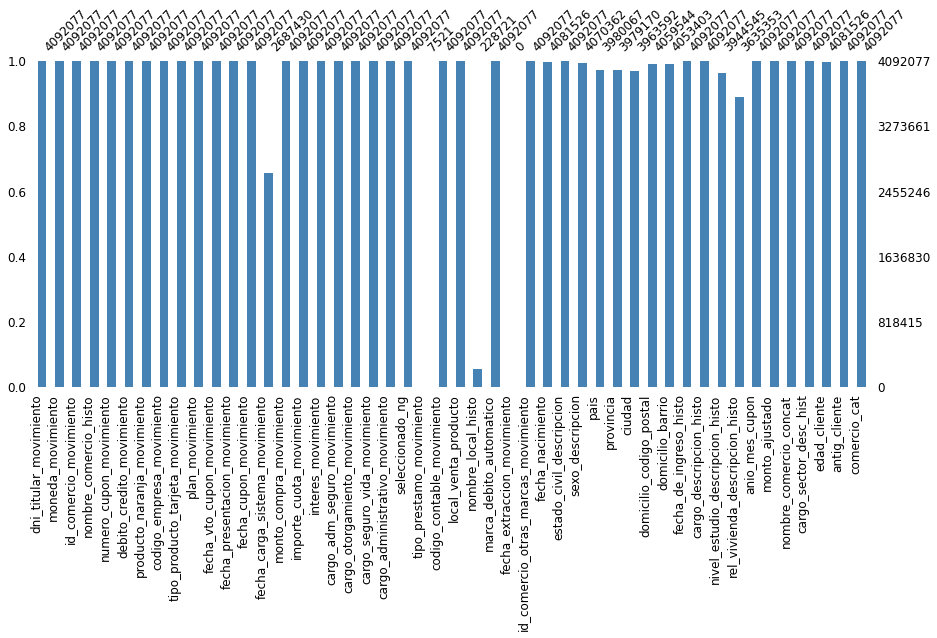

In [73]:
ax = msno.bar(df,figsize=(15, 6), fontsize=12, color='steelblue')
ax.tick_params('x', rotation=90)

In [74]:
# how many total missing values do we have?
total_cells = np.product(df.shape)
total_missing = missing_values_count.sum()

# percent of data that is missing
print('Porcentaje de valores en nulo:',"{:.0%}".format(total_missing/total_cells))

Porcentaje de valores en nulo: 7%


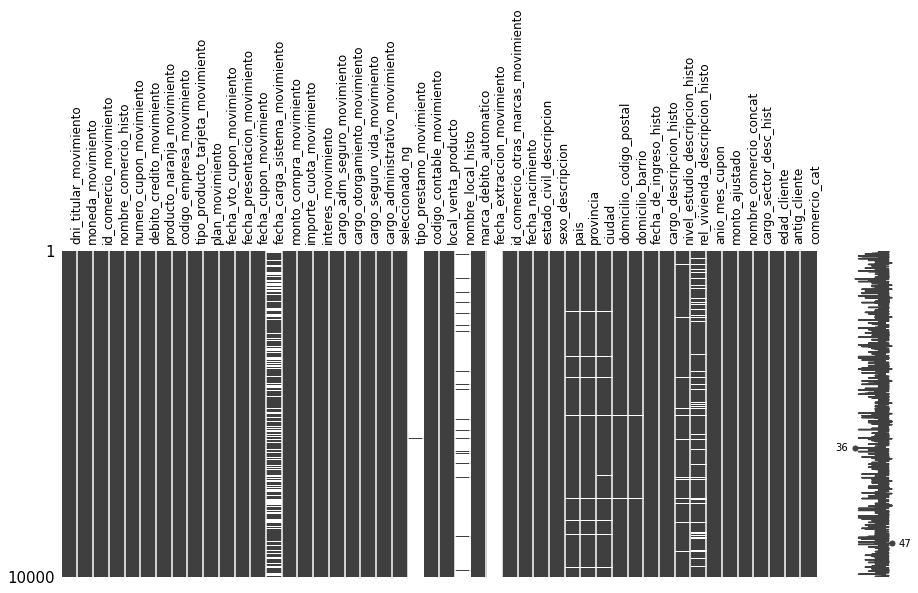

In [75]:
#usamos sample porque da error con todo el datas
df_ms = df.sample(10000)
ax = msno.matrix(df_ms,figsize=(15, 6),fontsize=12)
ax.tick_params('x', rotation=90)

Se puede observar cierta sistematicidad en la pérdida de valores relacionados a datos personales de los clientes. A continuación procedemos a analizar cada columna con valores faltantes.

#### Fecha carga sistema movimiento

In [76]:
print('fecha_cupon vs fecha_carga:')
df["fecha_cupon_movimiento"].dt.date.corr(
    df["fecha_carga_sistema_movimiento"].dt.date, method = 'spearman', min_periods = 1)

fecha_cupon vs fecha_carga:


0.9984268156536263

A la hora de evaluar la reimputación de valores nulos en esta columna, decidimos, en primer lugar, considerar la utilidad que podriamos llegar a darle en un futuro. Al calcular su correlación con la columna **fecha_cupon_movimiento**, podemos observar que tienen una relación lineal fuerte, por lo cual decidimos no tener en cuenta esta columna para analisis posteriores.

In [77]:
df.drop('fecha_carga_sistema_movimiento', axis=1, inplace=True)

#### Tipo_prestamo_movimiento, Nombre_local_histo y Fecha_extraccion_movimiento 

Las variables tipo_prestamo_movimiento, nombre_local_histo y fecha_extraccion_movimiento poseen una pérdida muy alta de valores (fecha extracción tiene todos valores nulos), por lo cuál la mejor decisión seria no tenerlas en cuenta en los siguientes análisis.

In [78]:
df.drop(columns = ['tipo_prestamo_movimiento','nombre_local_histo','fecha_extraccion_movimiento'], inplace=True)

#### Datos Faltantes Personales de los clientes

In [79]:
col_pers = ['fecha_nacimiento', 'pais', 'domicilio_codigo_postal', 'sexo_descripcion',
           'provincia', 'dni_titular_movimiento', 'ciudad', 'edad_cliente', 'domicilio_barrio']

In [80]:
df_faltante_fech= pd.DataFrame(df[df['fecha_nacimiento'].isna()])
df_faltante_fech[col_pers].isna().sum()

fecha_nacimiento           10551
pais                       10551
domicilio_codigo_postal    10551
sexo_descripcion           10551
provincia                  10551
dni_titular_movimiento         0
ciudad                     10551
edad_cliente               10551
domicilio_barrio           10551
dtype: int64

In [81]:
df_faltante_fech.dni_titular_movimiento.value_counts()

000cde1ad5d8114e7a5dd977930b8835659    8481
000650e8144e3a42d47a21aee9e48f34804    1380
000b0d85fa8a959e2133328830fff990443     690
Name: dni_titular_movimiento, dtype: int64

In [82]:
dni859 = df[(df["dni_titular_movimiento"] =="000cde1ad5d8114e7a5dd977930b8835659")]
dni859.shape

(8481, 44)

In [83]:
dni804 = df[(df["dni_titular_movimiento"] =="000650e8144e3a42d47a21aee9e48f34804")]
dni804.shape

(1380, 44)

In [84]:
dni443 = df[(df["dni_titular_movimiento"] =="000b0d85fa8a959e2133328830fff990443")]
dni443.shape

(690, 44)

Se observa que son 3 los clientes que tienen valores faltantes en las columnas fecha_nacimiento, sexo_descripcion, pais, provincia, ciudad, domicilio_codigo_postal y domicilio_barrio. Corresponden a información personal de los mismos, que no puede ser recuperada de otra forma. Es una pérdida sistemática NMAR.

In [85]:
df_faltante_sexo = pd.DataFrame(df[df['sexo_descripcion'].isna()])
df_faltante_sexo[col_pers].isna().sum()

fecha_nacimiento           10551
pais                       11172
domicilio_codigo_postal    10551
sexo_descripcion           21715
provincia                  11172
dni_titular_movimiento         0
ciudad                     11172
edad_cliente               10551
domicilio_barrio           10551
dtype: int64

In [86]:
df_faltante_sexo.dni_titular_movimiento.value_counts()

000cde1ad5d8114e7a5dd977930b8835659    8481
000055175fe76d2c4b0ca52f904b0c0c903    7590
00017733df45bb08ee7abd44e6037cf7471    1918
000650e8144e3a42d47a21aee9e48f34804    1380
0006e947a6f89a8bcb835ae85c60ff93526    1035
000b0d85fa8a959e2133328830fff990443     690
000e5f85c3a5e3fe6dc1f214f01f55ae617     621
Name: dni_titular_movimiento, dtype: int64

In [87]:
dni903 = df[(df["dni_titular_movimiento"] =="000055175fe76d2c4b0ca52f904b0c0c903")]
dni903.shape

(7590, 44)

In [88]:
dni471 = df[(df["dni_titular_movimiento"] =="00017733df45bb08ee7abd44e6037cf7471")]
dni471.shape

(1918, 44)

In [89]:
dni526 = df[(df["dni_titular_movimiento"] =="0006e947a6f89a8bcb835ae85c60ff93526")]
dni526.shape

(1035, 44)

In [90]:
dni617 = df[(df["dni_titular_movimiento"] =="000e5f85c3a5e3fe6dc1f214f01f55ae617")]
dni617.shape

(621, 44)

Podemos decir que el resto de los dni a los que les falta el dato de sexo_descripcion tambien corresponden a una perdida sistematica, no puediendose recuperar dicho dato.

Procedemos a imputar con 'Sin Datos' a los valores faltantes en la columna sexo_descripcion.

In [91]:
columna = ['sexo_descripcion']
#df['sexo_descripcion']= df.sexo_descripcion.fillna(value=np.nan)
const_imputer = SimpleImputer(missing_values= np.nan, strategy='constant',fill_value="Sin Datos") 
df.loc[ : , columna] = pd.DataFrame(const_imputer.fit_transform(df.loc[:][columna]) , columns = columna)

In [92]:
#df['sexo_descripcion'] = df['sexo_descripcion'].astype(str)
df['sexo_descripcion'].value_counts()

Mujer        2161919
Hombre       1908443
Sin Datos      21715
Name: sexo_descripcion, dtype: int64

Procedemos a imputar usando IterativeImputer (en su operación por defecto BayesianRigde) la variable edad_cliente. Para imputar usamos las columnas **edad_cliente** y **antig_cliente**.

In [93]:
imp = IterativeImputer(max_iter=10, random_state=0)
imp_columns = ['edad_cliente', 'antig_cliente']
x_train = df[imp_columns]
imp.fit(x_train)

x_test = df[imp_columns]
x_test = np.round(imp.transform(x_test))
x_test = pd.DataFrame(x_test, columns=imp_columns)
x_test

,edad_cliente,antig_cliente
0,61.0,92.0
1,29.0,2.0
2,28.0,95.0
3,40.0,151.0
4,36.0,87.0
...,...,...
4092072,45.0,261.0
4092073,45.0,261.0
4092074,45.0,261.0
4092075,45.0,261.0


In [94]:
df['edad_cliente'] = x_test['edad_cliente']

In [95]:
df['edad_cliente'].describe().round(2)

count    4092077.00
mean          49.67
std           15.11
min           19.00
25%           37.00
50%           47.00
75%           62.00
max          110.00
Name: edad_cliente, dtype: float64

La columna fecha_nacimiento se deja sin imputar debido a que su unica finalidad era obtener la edad del cliente. Por lo tanto, no se tiene en cuenta.

In [96]:
df.drop('fecha_nacimiento', inplace=True, axis=1)

#### Datos Faltantes Geograficos de los clientes

##### Sistematicidad en la pérdida

In [97]:
col_geo = ['domicilio_codigo_postal', 'pais', 'provincia', 'ciudad', 'domicilio_barrio']
df[df['domicilio_codigo_postal'].isna()][col_geo].isna().sum()

domicilio_codigo_postal    32533
pais                       32533
provincia                  32533
ciudad                     32533
domicilio_barrio           32533
dtype: int64

In [98]:
df[df['domicilio_codigo_postal'].isna()].dni_titular_movimiento.value_counts()

000ca38416fd465eb043954922c6b585739    10764
000cde1ad5d8114e7a5dd977930b8835659     8481
000edf1f0ef2ba6fb1c639c4fb82133b037     4071
0002ae4acf8215290b73530d4820e198238     3726
00080a8a903ba92d2a2a4e0cc28fa9d8765     3076
000650e8144e3a42d47a21aee9e48f34804     1380
000b0d85fa8a959e2133328830fff990443      690
0009b382e7c4e4c8ec4a0b0459ca3ff6339      345
Name: dni_titular_movimiento, dtype: int64

In [99]:
dni739 = df[(df["dni_titular_movimiento"] =="000ca38416fd465eb043954922c6b585739")]
dni739.shape

(10764, 43)

In [100]:
dni037 = df[(df["dni_titular_movimiento"] =="000edf1f0ef2ba6fb1c639c4fb82133b037")]
dni037.shape

(4071, 43)

In [101]:
dni238 = df[(df["dni_titular_movimiento"] =="0002ae4acf8215290b73530d4820e198238")]
dni238.shape

(3726, 43)

In [102]:
dni765 = df[(df["dni_titular_movimiento"] =="00080a8a903ba92d2a2a4e0cc28fa9d8765")]
dni765.shape

(3076, 43)

In [103]:
dni339 = df[(df["dni_titular_movimiento"] =="0009b382e7c4e4c8ec4a0b0459ca3ff6339")]
dni339.shape

(345, 43)

Podemos decir que a los dni que les faltan todos sus datos geográficos corresponden a una pérdida sistemática, la cual no se puede recuperar. 

##### Reimputación con datos geográficos presentes

Intentaremos recuperar las filas donde haya algún dato geográfico presente que permita reimputar los faltantes. Para esto, observamos la cantidad de provincias en nuestro dataframe.

In [104]:
pd.DataFrame({'Provincias': df['provincia'].unique()})\
    .sort_values(by='Provincias',ascending=True)\
    .reset_index().drop(columns=['index'])

,Provincias
0,BUENOS AIRES
1,CAPITAL FEDERAL
2,CATAMARCA
3,CHACO
4,CHUBUT
5,CORDOBA
6,CORRIENTES
7,ENTRE RIOS
8,FORMOSA
9,JUJUY


Tenemos un total de 24 provincias, el resto son registros NaN.

In [105]:
df['domicilio_codigo_postal'].unique()

array(['1766', '5521', '7107', '2200', '1019', '5700', '5280', '5501',
       '3600', '1744', '2000', '3500', '1625', '8355', '2132', '1891',
       '1419', '8300', '5570', '4700', '9420', '3409', '2630', '1874',
       '1900', '4634', '3000', '4400', '5903', '5006', '2002', '5300',
       '2400', '6000', '3450', '1826', '4152', '5442', '5800', '4230',
       '3400', '8336', '5513', '5000', '5577', '5004', '1824', '4000',
       '8430', '1214', '8340', '5900', '1914', '5519', '3300', '5014',
       '5236', '4415', '5413', '5001', '1408', '5509', '1120', '7165',
       '5013', '1619', '3100', '8318', '2006', '4401', '1648', '4119',
       nan, '5021', '3200', '5008', '9210', '1878', '5573', '5803',
       '5980', '2008', '5016', '5541', '5152', '5214', '1028', '5223',
       '1650', '5022', '2918', '3706', '4101', '4200', '5825', '7600',
       '5500', '5196', '3560', '4308', '4174', '5109', '4600', '9000',
       '5535', '5123', '5017', '6300', '5012', '3730', '5009', '1832',
       '5

In [106]:
df[df['domicilio_codigo_postal'].str.len()<4][['pais','provincia','ciudad','domicilio_codigo_postal']].drop_duplicates()

,pais,provincia,ciudad,domicilio_codigo_postal
833482,Argentina,NaN,NaN,0
1898899,Argentina,TUCUMAN,CAMPO HERRERA,400


Observamos que tenemos datos erróneos de código postal con valores de 0 y 400. 

Analizaremos si podemos recuperar el código postal de la localidad de **Campo Herrera**. El Código Postal en 0 lo imputaremos por NaN.

In [107]:
print('Cantidad de filas con Cero:', len(df[df['domicilio_codigo_postal']=='0']))
df[df['domicilio_codigo_postal']=='0'].head()

Cantidad de filas con Cero: 897


,dni_titular_movimiento,moneda_movimiento,id_comercio_movimiento,nombre_comercio_histo,numero_cupon_movimiento,debito_credito_movimiento,producto_naranja_movimiento,codigo_empresa_movimiento,tipo_producto_tarjeta_movimiento,plan_movimiento,fecha_vto_cupon_movimiento,fecha_presentacion_movimiento,fecha_cupon_movimiento,monto_compra_movimiento,importe_cuota_movimiento,interes_movimiento,cargo_adm_seguro_movimiento,cargo_otorgamiento_movimiento,cargo_seguro_vida_movimiento,cargo_administrativo_movimiento,seleccionado_ng,codigo_contable_movimiento,local_venta_producto,marca_debito_automatico,id_comercio_otras_marcas_movimiento,estado_civil_descripcion,sexo_descripcion,pais,provincia,ciudad,domicilio_codigo_postal,domicilio_barrio,fecha_de_ingreso_histo,cargo_descripcion_histo,nivel_estudio_descripcion_histo,rel_vivienda_descripcion_histo,anio_mes_cupon,monto_ajustado,nombre_comercio_concat,cargo_sector_desc_hist,edad_cliente,antig_cliente,comercio_cat
833482,00073e893b40d39e8be8bf7e74c51737985,0,020099902,COMISION POR MANTENIMDE CTA,999990,0,PL,1,0,1,2021-05-10,2021-04-25,2021-04-25,354.53,354.53,0.0,0.0,0.0,0.0,0.0,0,209,20099902,0,0,Solteroa,Mujer,Argentina,NaN,NaN,0,NaN,2021-04-15,SIN DATOS,NaN,NaN,202104,247.06,COMISION POR MANTENIMDE CTA,Sector_Sin_Datos,36.0,0,0
834175,00073e893b40d39e8be8bf7e74c51737985,0,020099902,COMISION POR MANTENIMDE CTA,999990,0,PL,1,0,1,2021-05-10,2021-04-25,2021-04-25,354.53,354.53,0.0,0.0,0.0,0.0,0.0,0,209,20099902,0,0,Solteroa,Mujer,Argentina,NaN,NaN,0,NaN,2021-04-15,SIN DATOS,NaN,NaN,202104,247.06,COMISION POR MANTENIMDE CTA,Sector_Sin_Datos,36.0,0,0
834868,00073e893b40d39e8be8bf7e74c51737985,0,020099902,COMISION POR MANTENIMDE CTA,999990,0,PL,1,0,1,2021-05-10,2021-04-25,2021-04-25,354.53,354.53,0.0,0.0,0.0,0.0,0.0,0,209,20099902,0,0,Solteroa,Mujer,Argentina,NaN,NaN,0,NaN,2021-04-15,SIN DATOS,NaN,NaN,202104,247.06,COMISION POR MANTENIMDE CTA,Sector_Sin_Datos,36.0,0,0
835561,00073e893b40d39e8be8bf7e74c51737985,0,020099902,COMISION POR MANTENIMDE CTA,999990,0,PL,1,0,1,2021-05-10,2021-04-25,2021-04-25,354.53,354.53,0.0,0.0,0.0,0.0,0.0,0,209,20099902,0,0,Solteroa,Mujer,Argentina,NaN,NaN,0,NaN,2021-04-15,SIN DATOS,NaN,NaN,202104,247.06,COMISION POR MANTENIMDE CTA,Sector_Sin_Datos,36.0,0,0
836254,00073e893b40d39e8be8bf7e74c51737985,0,020099902,COMISION POR MANTENIMDE CTA,999990,0,PL,1,0,1,2021-05-10,2021-04-25,2021-04-25,354.53,354.53,0.0,0.0,0.0,0.0,0.0,0,209,20099902,0,0,Solteroa,Mujer,Argentina,NaN,NaN,0,NaN,2021-04-15,SIN DATOS,NaN,NaN,202104,247.06,COMISION POR MANTENIMDE CTA,Sector_Sin_Datos,36.0,0,0


In [108]:
df['domicilio_codigo_postal'] = df['domicilio_codigo_postal'].replace('0',np.nan)
df[df['domicilio_codigo_postal']=='0']

,dni_titular_movimiento,moneda_movimiento,id_comercio_movimiento,nombre_comercio_histo,numero_cupon_movimiento,debito_credito_movimiento,producto_naranja_movimiento,codigo_empresa_movimiento,tipo_producto_tarjeta_movimiento,plan_movimiento,fecha_vto_cupon_movimiento,fecha_presentacion_movimiento,fecha_cupon_movimiento,monto_compra_movimiento,importe_cuota_movimiento,interes_movimiento,cargo_adm_seguro_movimiento,cargo_otorgamiento_movimiento,cargo_seguro_vida_movimiento,cargo_administrativo_movimiento,seleccionado_ng,codigo_contable_movimiento,local_venta_producto,marca_debito_automatico,id_comercio_otras_marcas_movimiento,estado_civil_descripcion,sexo_descripcion,pais,provincia,ciudad,domicilio_codigo_postal,domicilio_barrio,fecha_de_ingreso_histo,cargo_descripcion_histo,nivel_estudio_descripcion_histo,rel_vivienda_descripcion_histo,anio_mes_cupon,monto_ajustado,nombre_comercio_concat,cargo_sector_desc_hist,edad_cliente,antig_cliente,comercio_cat


In [109]:
df['ciudad'] = df['ciudad'].str.strip()
print('Cantidad de filas con 400 en el CP:',len(df[df['ciudad'].isin(['CAMPO HERRERA'])]))
df[df['ciudad'].isin(['CAMPO HERRERA'])][['pais','provincia','ciudad','domicilio_codigo_postal']].drop_duplicates()

Cantidad de filas con 400 en el CP: 690


,pais,provincia,ciudad,domicilio_codigo_postal
1898899,Argentina,TUCUMAN,CAMPO HERRERA,400


Obteniendo el dato de una fuente externa, vamos a reemplazar el código postal de la ciudad Campo Herrera en la provincia Tucumán por el valor correcto.

Fuente: https://codigo-postal.co/argentina/tucuman/campo-herrera/

In [110]:
df.loc[df['ciudad'].isin(['CAMPO HERRERA']),'domicilio_codigo_postal'] = '4105'
print('Cantidad de filas con 400 en el CP:',len(df[df['ciudad'].isin(['CAMPO HERRERA'])]))
df[df['ciudad'].isin(['CAMPO HERRERA'])][['pais','provincia','ciudad','domicilio_codigo_postal']].drop_duplicates()

Cantidad de filas con 400 en el CP: 690


,pais,provincia,ciudad,domicilio_codigo_postal
1898899,Argentina,TUCUMAN,CAMPO HERRERA,4105


In [111]:
df[df['pais'].isnull() == True][['pais','provincia','ciudad','domicilio_codigo_postal','domicilio_barrio']].drop_duplicates()

,pais,provincia,ciudad,domicilio_codigo_postal,domicilio_barrio
2674,NaN,NaN,NaN,5000,SAN VICENTE
2691,NaN,NaN,NaN,NaN,NaN
2763,NaN,NaN,NaN,5501,FUCHS 1
47711,NaN,NaN,NaN,5613,MALARGUE
47757,NaN,NaN,NaN,5800,VALACO
69580,NaN,NaN,NaN,4146,CONCEPCION
77981,NaN,NaN,NaN,2144,TOTORAS
78121,NaN,NaN,NaN,5907,SILVIO PELLICO
90122,NaN,NaN,NaN,1663,SARMIENTO
90159,NaN,NaN,NaN,8322,RUCA QUIMEY


Observamos que cuando **pais** es nulo, tambien lo son las variables **provincia** y **ciudad**. Primero vemos si existen datos dentro del dataset con los cuales imputar. 

In [112]:
df[(df['domicilio_codigo_postal'].isna()==True) & (df['ciudad'].isna()!=True)]

,dni_titular_movimiento,moneda_movimiento,id_comercio_movimiento,nombre_comercio_histo,numero_cupon_movimiento,debito_credito_movimiento,producto_naranja_movimiento,codigo_empresa_movimiento,tipo_producto_tarjeta_movimiento,plan_movimiento,fecha_vto_cupon_movimiento,fecha_presentacion_movimiento,fecha_cupon_movimiento,monto_compra_movimiento,importe_cuota_movimiento,interes_movimiento,cargo_adm_seguro_movimiento,cargo_otorgamiento_movimiento,cargo_seguro_vida_movimiento,cargo_administrativo_movimiento,seleccionado_ng,codigo_contable_movimiento,local_venta_producto,marca_debito_automatico,id_comercio_otras_marcas_movimiento,estado_civil_descripcion,sexo_descripcion,pais,provincia,ciudad,domicilio_codigo_postal,domicilio_barrio,fecha_de_ingreso_histo,cargo_descripcion_histo,nivel_estudio_descripcion_histo,rel_vivienda_descripcion_histo,anio_mes_cupon,monto_ajustado,nombre_comercio_concat,cargo_sector_desc_hist,edad_cliente,antig_cliente,comercio_cat


In [113]:
df[(df['domicilio_codigo_postal'].isna()==True) & (df['provincia'].isna()!=True)]

,dni_titular_movimiento,moneda_movimiento,id_comercio_movimiento,nombre_comercio_histo,numero_cupon_movimiento,debito_credito_movimiento,producto_naranja_movimiento,codigo_empresa_movimiento,tipo_producto_tarjeta_movimiento,plan_movimiento,fecha_vto_cupon_movimiento,fecha_presentacion_movimiento,fecha_cupon_movimiento,monto_compra_movimiento,importe_cuota_movimiento,interes_movimiento,cargo_adm_seguro_movimiento,cargo_otorgamiento_movimiento,cargo_seguro_vida_movimiento,cargo_administrativo_movimiento,seleccionado_ng,codigo_contable_movimiento,local_venta_producto,marca_debito_automatico,id_comercio_otras_marcas_movimiento,estado_civil_descripcion,sexo_descripcion,pais,provincia,ciudad,domicilio_codigo_postal,domicilio_barrio,fecha_de_ingreso_histo,cargo_descripcion_histo,nivel_estudio_descripcion_histo,rel_vivienda_descripcion_histo,anio_mes_cupon,monto_ajustado,nombre_comercio_concat,cargo_sector_desc_hist,edad_cliente,antig_cliente,comercio_cat


No es posible recuperar el código postal a través de las variables **provincia** o **ciudad**.

In [114]:
df[(df['domicilio_codigo_postal'].isna()!=True) & (df['ciudad'].isna()==True)][['domicilio_codigo_postal','ciudad']].drop_duplicates()

,domicilio_codigo_postal,ciudad
2623,4400,NaN
2674,5000,NaN
2763,5501,NaN
13626,5101,NaN
47711,5613,NaN
47757,5800,NaN
69580,4146,NaN
77981,2144,NaN
78121,5907,NaN
90122,1663,NaN


Sin embargo, analizaremos si podemos recuperar los datos de **provincia** y **ciudad** a través de **domicilio_codigo_postal** dentro de nuestro dataset.

In [115]:
cp_ciu_nan = df[(df['domicilio_codigo_postal'].isna()!=True) & (df['ciudad'].isna()==True)]['domicilio_codigo_postal'].unique()
df[df['domicilio_codigo_postal'].isin(cp_ciu_nan)][['domicilio_codigo_postal','ciudad']]\
.drop_duplicates().sort_values(by=['domicilio_codigo_postal'])

,domicilio_codigo_postal,ciudad
194109,1130,NaN
104398,1663,SAN MIGUEL
90122,1663,NaN
77981,2144,NaN
1898906,2506,NaN
1898980,2705,NaN
601271,2812,NaN
786545,3230,NaN
1898916,3240,NaN
2662,3300,POSADAS


In [116]:
df.loc[:,'ciudad'] = df['ciudad'].str.upper()
df_dp_cd = df[(df['domicilio_codigo_postal'].isin(cp_ciu_nan)) & (df['ciudad'].isna()==False)]\
            [['domicilio_codigo_postal','ciudad']]\
            .drop_duplicates()\
            .sort_values(by=['domicilio_codigo_postal'])
df_dp_cd = df_dp_cd.rename(columns={'ciudad': 'ciudad_0', 'domicilio_codigo_postal': 'cp'})
df_dp_cd

,cp,ciudad_0
104398,1663,SAN MIGUEL
2662,3300,POSADAS
897,3500,RESISTENCIA
24722,3503,LA LEONESA
2651,4000,SAN MIGUEL DE TUCUMAN
69493,4000,TUCUMAN
2720,4101,SAN MIGUEL DE TUCUMAN
24647,4101,LAS TALITASTUCUMAN
2635,4400,SALTA
2646,5000,CORDOBA


Realizamos merge sobre el dataframe creado, e imputamos los datos de ciudad.

In [117]:
df = df.merge(df_dp_cd.drop_duplicates(subset=['cp'], keep='first'), 
              how='left',
              left_on = 'domicilio_codigo_postal', 
              right_on = 'cp')\
            .drop(columns= ['cp'])
df.head()

,dni_titular_movimiento,moneda_movimiento,id_comercio_movimiento,nombre_comercio_histo,numero_cupon_movimiento,debito_credito_movimiento,producto_naranja_movimiento,codigo_empresa_movimiento,tipo_producto_tarjeta_movimiento,plan_movimiento,fecha_vto_cupon_movimiento,fecha_presentacion_movimiento,fecha_cupon_movimiento,monto_compra_movimiento,importe_cuota_movimiento,interes_movimiento,cargo_adm_seguro_movimiento,cargo_otorgamiento_movimiento,cargo_seguro_vida_movimiento,cargo_administrativo_movimiento,seleccionado_ng,codigo_contable_movimiento,local_venta_producto,marca_debito_automatico,id_comercio_otras_marcas_movimiento,estado_civil_descripcion,sexo_descripcion,pais,provincia,ciudad,domicilio_codigo_postal,domicilio_barrio,fecha_de_ingreso_histo,cargo_descripcion_histo,nivel_estudio_descripcion_histo,rel_vivienda_descripcion_histo,anio_mes_cupon,monto_ajustado,nombre_comercio_concat,cargo_sector_desc_hist,edad_cliente,antig_cliente,comercio_cat,ciudad_0
0,0001686b52949b5461ffcbc766687e45031,0,020099784,INTERES POR MORA US,200813,0,PL,1,0,1,2020-09-10,2020-08-25,2020-08-25,6.24,6.24,0.0,0.0,0.0,0.0,0.0,0,281,20099784,0,0,Divorciadoa,Hombre,Argentina,BUENOS AIRES,LA TABLADA,1766,LA TABLADA,2012-12-11,EMPDE COMERCIO,SECUNDARIOS,Propia,202008,5.52,INTERES POR MORA US,Sector_Empleado_Comercio,61.0,92,0,NaN
1,000220fa96ec5af89817894033f8099c547,0,020099784,INTERES POR MORA US,200813,0,PL,1,0,1,2020-09-10,2020-08-25,2020-08-25,17.73,17.73,0.0,0.0,0.0,0.0,0.0,0,281,20099784,0,0,Sin Datos,Mujer,Argentina,MENDOZA,VANVA DE GUAYMALLEN,5521,GLLEN,2020-06-10,SIN DATOS,NaN,NaN,202008,15.68,INTERES POR MORA US,Sector_Sin_Datos,29.0,2,0,NaN
2,0002be202de47dfae9cc2304d91161be595,0,020099784,INTERES POR MORA US,200813,0,PL,1,0,1,2020-09-10,2020-08-25,2020-08-25,6.18,6.18,0.0,0.0,0.0,0.0,0.0,0,281,20099784,0,0,Solteroa,Mujer,Argentina,BUENOS AIRES,SANTA TERESITA,7107,SANTA TERESITA,2012-09-13,SIN DATOS,PRIMARIOS,Otros,202008,5.46,INTERES POR MORA US,Sector_Sin_Datos,28.0,95,0,NaN
3,000e137d0af42e193be1ff670c00d4d1506,0,020099784,INTERES POR MORA US,200813,0,PL,1,0,1,2020-09-10,2020-08-25,2020-08-25,2.83,2.83,0.0,0.0,0.0,0.0,0.0,0,281,20099784,0,0,Solteroa,Hombre,Argentina,SANTA FE,SAN LORENZO,2200,BOUCHARD,2008-01-15,EMPDE COMERCIO,SECUNDARIOS,Propia,202008,2.50,INTERES POR MORA US,Sector_Empleado_Comercio,40.0,151,0,NaN
4,0009d010e4faf69552a814a33832b185877,0,020099784,INTERES POR MORA US,200813,0,PL,1,0,1,2020-09-10,2020-08-25,2020-08-25,2.38,2.38,0.0,0.0,0.0,0.0,0.0,0,281,20099784,0,0,Solteroa,Mujer,Argentina,CAPITAL FEDERAL,CIUDAD AUTONOMA DE BUENOS AIRES,1019,SAN NICOLAS,2013-06-06,EMPDE COMERCIO,UNIVERSITARIOS,Alquilada,202008,2.10,INTERES POR MORA US,Sector_Empleado_Comercio,36.0,87,0,NaN


In [118]:
# Sustituimos los valores nulos de la columna provincia (provincia_x) por las provincias (en mayus) de la columna
# provincia creada en la anterior unión.
df.loc[df['ciudad'].isnull(), 'ciudad'] = df['ciudad_0'].str.upper()

df[(df['domicilio_codigo_postal'].isin(cp_ciu_nan)) & (df['ciudad'].isna()==True)]\
    [['domicilio_codigo_postal','ciudad','ciudad_0']].drop_duplicates().sort_values(by=['domicilio_codigo_postal'])

,domicilio_codigo_postal,ciudad,ciudad_0
194109,1130,NaN,NaN
77981,2144,NaN,NaN
1898906,2506,NaN,NaN
1898980,2705,NaN,NaN
601271,2812,NaN,NaN
786545,3230,NaN,NaN
1898916,3240,NaN,NaN
69580,4146,NaN,NaN
1898924,5019,NaN,NaN
13626,5101,NaN,NaN


In [119]:
df = df.drop(columns=['ciudad_0'])

Procedemos a imputar **provincia** de la misma manera que **ciudad**.

In [120]:
cp_prov_nan = df[(df['domicilio_codigo_postal'].isna()!=True) & (df['provincia'].isna()==True)]['domicilio_codigo_postal'].unique()
df[df['domicilio_codigo_postal'].isin(cp_prov_nan)][['domicilio_codigo_postal','provincia']]\
.drop_duplicates().sort_values(by=['domicilio_codigo_postal'])

,domicilio_codigo_postal,provincia
194109,1130,NaN
104398,1663,BUENOS AIRES
90122,1663,NaN
77981,2144,NaN
1898980,2705,NaN
601271,2812,NaN
786545,3230,NaN
2662,3300,MISIONES
833346,3300,NaN
897,3500,CHACO


In [121]:
df.loc[:,'provincia'] = df['provincia'].str.upper()
df_dp_pv = df[(df['domicilio_codigo_postal'].isin(cp_ciu_nan)) & (df['provincia'].isna()==False)]\
            [['domicilio_codigo_postal','provincia']]\
            .drop_duplicates()\
            .sort_values(by=['domicilio_codigo_postal'])
df_dp_pv = df_dp_pv.rename(columns={'provincia': 'provincia_0', 'domicilio_codigo_postal': 'cp'})
df_dp_pv

,cp,provincia_0
104398,1663,BUENOS AIRES
1898906,2506,SANTA FE
1898916,3240,ENTRE RIOS
2662,3300,MISIONES
897,3500,CHACO
24722,3503,CHACO
2651,4000,TUCUMAN
2720,4101,TUCUMAN
2623,4400,SALTA
2646,5000,CORDOBA


In [122]:
df = df.merge(df_dp_pv.drop_duplicates(subset=['cp'], keep='first'), 
              how='left',
              left_on = 'domicilio_codigo_postal', 
              right_on = 'cp')\
            .drop(columns= ['cp'])
df.head()

,dni_titular_movimiento,moneda_movimiento,id_comercio_movimiento,nombre_comercio_histo,numero_cupon_movimiento,debito_credito_movimiento,producto_naranja_movimiento,codigo_empresa_movimiento,tipo_producto_tarjeta_movimiento,plan_movimiento,fecha_vto_cupon_movimiento,fecha_presentacion_movimiento,fecha_cupon_movimiento,monto_compra_movimiento,importe_cuota_movimiento,interes_movimiento,cargo_adm_seguro_movimiento,cargo_otorgamiento_movimiento,cargo_seguro_vida_movimiento,cargo_administrativo_movimiento,seleccionado_ng,codigo_contable_movimiento,local_venta_producto,marca_debito_automatico,id_comercio_otras_marcas_movimiento,estado_civil_descripcion,sexo_descripcion,pais,provincia,ciudad,domicilio_codigo_postal,domicilio_barrio,fecha_de_ingreso_histo,cargo_descripcion_histo,nivel_estudio_descripcion_histo,rel_vivienda_descripcion_histo,anio_mes_cupon,monto_ajustado,nombre_comercio_concat,cargo_sector_desc_hist,edad_cliente,antig_cliente,comercio_cat,provincia_0
0,0001686b52949b5461ffcbc766687e45031,0,020099784,INTERES POR MORA US,200813,0,PL,1,0,1,2020-09-10,2020-08-25,2020-08-25,6.24,6.24,0.0,0.0,0.0,0.0,0.0,0,281,20099784,0,0,Divorciadoa,Hombre,Argentina,BUENOS AIRES,LA TABLADA,1766,LA TABLADA,2012-12-11,EMPDE COMERCIO,SECUNDARIOS,Propia,202008,5.52,INTERES POR MORA US,Sector_Empleado_Comercio,61.0,92,0,NaN
1,000220fa96ec5af89817894033f8099c547,0,020099784,INTERES POR MORA US,200813,0,PL,1,0,1,2020-09-10,2020-08-25,2020-08-25,17.73,17.73,0.0,0.0,0.0,0.0,0.0,0,281,20099784,0,0,Sin Datos,Mujer,Argentina,MENDOZA,VANVA DE GUAYMALLEN,5521,GLLEN,2020-06-10,SIN DATOS,NaN,NaN,202008,15.68,INTERES POR MORA US,Sector_Sin_Datos,29.0,2,0,NaN
2,0002be202de47dfae9cc2304d91161be595,0,020099784,INTERES POR MORA US,200813,0,PL,1,0,1,2020-09-10,2020-08-25,2020-08-25,6.18,6.18,0.0,0.0,0.0,0.0,0.0,0,281,20099784,0,0,Solteroa,Mujer,Argentina,BUENOS AIRES,SANTA TERESITA,7107,SANTA TERESITA,2012-09-13,SIN DATOS,PRIMARIOS,Otros,202008,5.46,INTERES POR MORA US,Sector_Sin_Datos,28.0,95,0,NaN
3,000e137d0af42e193be1ff670c00d4d1506,0,020099784,INTERES POR MORA US,200813,0,PL,1,0,1,2020-09-10,2020-08-25,2020-08-25,2.83,2.83,0.0,0.0,0.0,0.0,0.0,0,281,20099784,0,0,Solteroa,Hombre,Argentina,SANTA FE,SAN LORENZO,2200,BOUCHARD,2008-01-15,EMPDE COMERCIO,SECUNDARIOS,Propia,202008,2.50,INTERES POR MORA US,Sector_Empleado_Comercio,40.0,151,0,NaN
4,0009d010e4faf69552a814a33832b185877,0,020099784,INTERES POR MORA US,200813,0,PL,1,0,1,2020-09-10,2020-08-25,2020-08-25,2.38,2.38,0.0,0.0,0.0,0.0,0.0,0,281,20099784,0,0,Solteroa,Mujer,Argentina,CAPITAL FEDERAL,CIUDAD AUTONOMA DE BUENOS AIRES,1019,SAN NICOLAS,2013-06-06,EMPDE COMERCIO,UNIVERSITARIOS,Alquilada,202008,2.10,INTERES POR MORA US,Sector_Empleado_Comercio,36.0,87,0,NaN


In [123]:
# Sustituimos los valores nulos de la columna provincia (provincia_0) por las provincias (en mayus) de la columna
# provincia creada en la anterior unión.

df.loc[df['provincia'].isnull(), 'provincia'] = df['provincia_0'].str.upper()

df[(df['domicilio_codigo_postal'].isin(cp_ciu_nan)) & (df['provincia'].isna()==True)]\
    [['domicilio_codigo_postal','provincia','provincia_0']].drop_duplicates().sort_values(by=['domicilio_codigo_postal'])

,domicilio_codigo_postal,provincia,provincia_0
194109,1130,NaN,NaN
77981,2144,NaN,NaN
1898980,2705,NaN,NaN
601271,2812,NaN,NaN
786545,3230,NaN,NaN
69580,4146,NaN,NaN
47711,5613,NaN,NaN
90159,8322,NaN,NaN
183610,9015,NaN,NaN


In [124]:
df = df.drop(columns=['provincia_0'])

In [125]:
df[col_geo].isna().sum()

domicilio_codigo_postal     33430
pais                       112010
provincia                   60760
ciudad                      70207
domicilio_barrio            38674
dtype: int64

Como podemos observar, existen datos nulos en **provincia** y **ciudad** que persistieron a la imputación anterior, por lo que decidimos buscar en un CSV externo los datos de Códigos Postales, Localidades y Provincias de Argentina.

##### Imputación con dataset externo

In [126]:
df_cp = pd.read_csv('https://raw.githubusercontent.com/JIBarrionuevoGaltier/localidades_AR/master/localidades_cp_maestro.csv')
df_cp.head()

,provincia,id,localidad,cp,id_prov_mstr
0,Ciudad Autonoma de Buenos Aires,5001,Ciudad Autonoma de Buenos Aires,NaN,2
1,Ciudad Autonoma de Buenos Aires,5001,Ciudad Autonoma de Buenos Aires,1144.0,2
2,Ciudad Autonoma de Buenos Aires,5001,Ciudad Autonoma de Buenos Aires,1145.0,2
3,Ciudad Autonoma de Buenos Aires,5001,Ciudad Autonoma de Buenos Aires,1146.0,2
4,Ciudad Autonoma de Buenos Aires,5001,Ciudad Autonoma de Buenos Aires,1147.0,2


In [127]:
# Realizamos una curación de datos sobre este dataset.

df_cp.cp = df_cp[df_cp['cp'].isna()!=True]['cp'].apply(int).apply(str)
df_cp.head()

,provincia,id,localidad,cp,id_prov_mstr
0,Ciudad Autonoma de Buenos Aires,5001,Ciudad Autonoma de Buenos Aires,NaN,2
1,Ciudad Autonoma de Buenos Aires,5001,Ciudad Autonoma de Buenos Aires,1144,2
2,Ciudad Autonoma de Buenos Aires,5001,Ciudad Autonoma de Buenos Aires,1145,2
3,Ciudad Autonoma de Buenos Aires,5001,Ciudad Autonoma de Buenos Aires,1146,2
4,Ciudad Autonoma de Buenos Aires,5001,Ciudad Autonoma de Buenos Aires,1147,2


Observamos si todos los Códigos Postales de nuestro DataFrame original se encuentran en los objetos del merge.

In [128]:
df_cp = df_cp[~df_cp['cp'].isnull()]
df_cp.isna().sum()

provincia       0
id              0
localidad       0
cp              0
id_prov_mstr    0
dtype: int64

In [129]:
pd.DataFrame({'Provincias': df_cp['provincia'].unique()})\
    .sort_values(by='Provincias',ascending=True)\
    .reset_index().drop(columns=['index'])

,Provincias
0,Buenos Aires
1,Catamarca
2,Chaco
3,Chubut
4,Ciudad Autonoma de Buenos Aires
5,Cordoba
6,Corrientes
7,Entre Rios
8,Formosa
9,Jujuy


In [130]:
df_cp.loc[df_cp['provincia'] == 'Ciudad Autonoma de Buenos Aires', 'provincia'] = 'CAPITAL FEDERAL'
df_cp.loc[df_cp['provincia'] == 'Santiago del Estero', 'provincia'] = 'SGO DEL ESTERO'
df_cp['provincia'].unique()

array(['CAPITAL FEDERAL', 'Buenos Aires', 'Catamarca', 'Cordoba',
       'Corrientes', 'Chaco', 'Chubut', 'Entre Rios', 'Formosa', 'Jujuy',
       'La Pampa', 'La Rioja', 'Mendoza', 'Misiones', 'Neuquen',
       'Rio Negro', 'Salta', 'San Juan', 'San Luis', 'Santa Cruz',
       'Santa Fe', 'SGO DEL ESTERO', 'Tucuman', 'Tierra del Fuego'],
      dtype=object)

In [131]:
df_cp.loc[:,'provincia'] = df_cp['provincia'].str.upper()
df_cp.loc[:,'localidad'] = df_cp['localidad'].str.upper()
df_cp[['provincia','localidad']].drop_duplicates()

,provincia,localidad
1,CAPITAL FEDERAL,CIUDAD AUTONOMA DE BUENOS AIRES
456,BUENOS AIRES,COLONIA VELEZ
457,BUENOS AIRES,SPURR
458,BUENOS AIRES,SPERONI
459,BUENOS AIRES,SPERATTI
...,...,...
23234,TIERRA DEL FUEGO,ESTANCIA SAN JULIO
23235,TIERRA DEL FUEGO,ESTANCIA SAN JUSTO
23236,TIERRA DEL FUEGO,ESTANCIA SAN MARTIN
23237,TIERRA DEL FUEGO,ESTANCIA RIO EWAN


In [132]:
df_cp = df_cp.rename(columns={'provincia': 'provincia_0'})
df_cp.head()

,provincia_0,id,localidad,cp,id_prov_mstr
1,CAPITAL FEDERAL,5001,CIUDAD AUTONOMA DE BUENOS AIRES,1144,2
2,CAPITAL FEDERAL,5001,CIUDAD AUTONOMA DE BUENOS AIRES,1145,2
3,CAPITAL FEDERAL,5001,CIUDAD AUTONOMA DE BUENOS AIRES,1146,2
4,CAPITAL FEDERAL,5001,CIUDAD AUTONOMA DE BUENOS AIRES,1147,2
5,CAPITAL FEDERAL,5001,CIUDAD AUTONOMA DE BUENOS AIRES,1148,2


In [133]:
df.shape

(4092077, 43)

Procedemos a hacer el merge de los datasets, a través de la columna cp (Codigo Postal)

In [134]:
# Unimos por cp, eliminamos duplicados, conservamos solo cps del dataframe original
df = df.merge(df_cp[['provincia_0','localidad','cp']].drop_duplicates(subset=['cp'], keep='first'), 
                           how='left',
                           left_on = 'domicilio_codigo_postal', 
                           right_on = 'cp')\
                    .drop(columns= ['cp'])
df.head()

,dni_titular_movimiento,moneda_movimiento,id_comercio_movimiento,nombre_comercio_histo,numero_cupon_movimiento,debito_credito_movimiento,producto_naranja_movimiento,codigo_empresa_movimiento,tipo_producto_tarjeta_movimiento,plan_movimiento,fecha_vto_cupon_movimiento,fecha_presentacion_movimiento,fecha_cupon_movimiento,monto_compra_movimiento,importe_cuota_movimiento,interes_movimiento,cargo_adm_seguro_movimiento,cargo_otorgamiento_movimiento,cargo_seguro_vida_movimiento,cargo_administrativo_movimiento,seleccionado_ng,codigo_contable_movimiento,local_venta_producto,marca_debito_automatico,id_comercio_otras_marcas_movimiento,estado_civil_descripcion,sexo_descripcion,pais,provincia,ciudad,domicilio_codigo_postal,domicilio_barrio,fecha_de_ingreso_histo,cargo_descripcion_histo,nivel_estudio_descripcion_histo,rel_vivienda_descripcion_histo,anio_mes_cupon,monto_ajustado,nombre_comercio_concat,cargo_sector_desc_hist,edad_cliente,antig_cliente,comercio_cat,provincia_0,localidad
0,0001686b52949b5461ffcbc766687e45031,0,020099784,INTERES POR MORA US,200813,0,PL,1,0,1,2020-09-10,2020-08-25,2020-08-25,6.24,6.24,0.0,0.0,0.0,0.0,0.0,0,281,20099784,0,0,Divorciadoa,Hombre,Argentina,BUENOS AIRES,LA TABLADA,1766,LA TABLADA,2012-12-11,EMPDE COMERCIO,SECUNDARIOS,Propia,202008,5.52,INTERES POR MORA US,Sector_Empleado_Comercio,61.0,92,0,BUENOS AIRES,LA TABLADA
1,000220fa96ec5af89817894033f8099c547,0,020099784,INTERES POR MORA US,200813,0,PL,1,0,1,2020-09-10,2020-08-25,2020-08-25,17.73,17.73,0.0,0.0,0.0,0.0,0.0,0,281,20099784,0,0,Sin Datos,Mujer,Argentina,MENDOZA,VANVA DE GUAYMALLEN,5521,GLLEN,2020-06-10,SIN DATOS,NaN,NaN,202008,15.68,INTERES POR MORA US,Sector_Sin_Datos,29.0,2,0,MENDOZA,VILLA NUEVA
2,0002be202de47dfae9cc2304d91161be595,0,020099784,INTERES POR MORA US,200813,0,PL,1,0,1,2020-09-10,2020-08-25,2020-08-25,6.18,6.18,0.0,0.0,0.0,0.0,0.0,0,281,20099784,0,0,Solteroa,Mujer,Argentina,BUENOS AIRES,SANTA TERESITA,7107,SANTA TERESITA,2012-09-13,SIN DATOS,PRIMARIOS,Otros,202008,5.46,INTERES POR MORA US,Sector_Sin_Datos,28.0,95,0,BUENOS AIRES,SANTA TERESITA
3,000e137d0af42e193be1ff670c00d4d1506,0,020099784,INTERES POR MORA US,200813,0,PL,1,0,1,2020-09-10,2020-08-25,2020-08-25,2.83,2.83,0.0,0.0,0.0,0.0,0.0,0,281,20099784,0,0,Solteroa,Hombre,Argentina,SANTA FE,SAN LORENZO,2200,BOUCHARD,2008-01-15,EMPDE COMERCIO,SECUNDARIOS,Propia,202008,2.50,INTERES POR MORA US,Sector_Empleado_Comercio,40.0,151,0,SANTA FE,SAN LORENZO
4,0009d010e4faf69552a814a33832b185877,0,020099784,INTERES POR MORA US,200813,0,PL,1,0,1,2020-09-10,2020-08-25,2020-08-25,2.38,2.38,0.0,0.0,0.0,0.0,0.0,0,281,20099784,0,0,Solteroa,Mujer,Argentina,CAPITAL FEDERAL,CIUDAD AUTONOMA DE BUENOS AIRES,1019,SAN NICOLAS,2013-06-06,EMPDE COMERCIO,UNIVERSITARIOS,Alquilada,202008,2.10,INTERES POR MORA US,Sector_Empleado_Comercio,36.0,87,0,CAPITAL FEDERAL,CIUDAD AUTONOMA DE BUENOS AIRES


In [135]:
df.loc[df['provincia'].isnull(), 'provincia'] = df['provincia_0'].str.upper()
df.loc[df['ciudad'].isnull(), 'ciudad'] = df['localidad'].str.upper()

In [136]:
df = df.drop(columns=['provincia_0','localidad'])

In [137]:
df[col_geo].isna().sum()

domicilio_codigo_postal     33430
pais                       112010
provincia                   33430
ciudad                      34120
domicilio_barrio            38674
dtype: int64

##### Conclusiones y decisiones

* La columna **pais** tiene una sola categoria: 'Argentina'. Sabiendo que todas los registros de la columna **provincia** que tienen datos pertenecen al territorio argentino, se puede descartar ya que no aporta información.
* La columna **domicilio_barrio** no aporta mayor información a la que ya se obtiene con el resto de las columnas geograficas, por lo que tambien se descarta. 
* Los valores faltantes de las columnas **domicilio_codigo_postal**, **provincia** y **ciudad** se imputaran con 'Sin Datos'

In [138]:
df.drop(columns=['pais','domicilio_barrio'], inplace=True)

In [139]:
columna = ['domicilio_codigo_postal', 'provincia', 'ciudad']
#df['sexo_descripcion']= df.sexo_descripcion.fillna(value=np.nan)
const_imputer = SimpleImputer(missing_values= np.nan, strategy='constant',fill_value="Sin Datos") 
df.loc[ : , columna] = pd.DataFrame(const_imputer.fit_transform(df.loc[:][columna]) , columns = columna)

In [140]:
df[['domicilio_codigo_postal', 'provincia', 'ciudad']].isna().sum()

domicilio_codigo_postal    0
provincia                  0
ciudad                     0
dtype: int64

#### Datos faltantes Nivel de Estudio

In [141]:
df.nivel_estudio_descripcion_histo.value_counts()

SECUNDARIOS       2184162
PRIMARIOS          996653
TERCIARIOS         470792
UNIVERSITARIOS     292938
Name: nivel_estudio_descripcion_histo, dtype: int64

In [142]:
columna = ['nivel_estudio_descripcion_histo']
#df["nivel_estudio_descripcion_histo"]= df.nivel_estudio_descripcion_histo.fillna(value=np.nan)
frec_imputer = SimpleImputer(missing_values = np.nan, strategy='most_frequent')
df.loc[ : , columna] = pd.DataFrame(frec_imputer.fit_transform(df.loc[:][columna]) , columns = columna)

In [143]:
df.nivel_estudio_descripcion_histo.value_counts()

SECUNDARIOS       2331694
PRIMARIOS          996653
TERCIARIOS         470792
UNIVERSITARIOS     292938
Name: nivel_estudio_descripcion_histo, dtype: int64

Se imputaron los valores nulos del nivel de estudio utilizando SimpleImputer con estrategia 'mas frecuente'

#### Datos faltantes Vivienda

In [144]:
df.rel_vivienda_descripcion_histo.value_counts()

Propia         2801068
Otros           354758
De familiar     341759
Alquilada       137768
Name: rel_vivienda_descripcion_histo, dtype: int64

In [145]:
columna = ['rel_vivienda_descripcion_histo']
#df["nivel_estudio_descripcion_histo"]= df.nivel_estudio_descripcion_histo.fillna(value=np.nan)
frec_imputer = SimpleImputer(missing_values = np.nan, strategy='most_frequent')
df.loc[ : , columna] = pd.DataFrame(frec_imputer.fit_transform(df.loc[:][columna]) , columns = columna)

In [146]:
df.rel_vivienda_descripcion_histo.value_counts()

Propia         3257792
Otros           354758
De familiar     341759
Alquilada       137768
Name: rel_vivienda_descripcion_histo, dtype: int64

Se imputaron los valores nulos de la vivienda utilizando SimpleImputer con estrategia 'mas frecuente'

In [147]:
df.isna().sum()

dni_titular_movimiento                 0
moneda_movimiento                      0
id_comercio_movimiento                 0
nombre_comercio_histo                  0
numero_cupon_movimiento                0
debito_credito_movimiento              0
producto_naranja_movimiento            0
codigo_empresa_movimiento              0
tipo_producto_tarjeta_movimiento       0
plan_movimiento                        0
fecha_vto_cupon_movimiento             0
fecha_presentacion_movimiento          0
fecha_cupon_movimiento                 0
monto_compra_movimiento                0
importe_cuota_movimiento               0
interes_movimiento                     0
cargo_adm_seguro_movimiento            0
cargo_otorgamiento_movimiento          0
cargo_seguro_vida_movimiento           0
cargo_administrativo_movimiento        0
seleccionado_ng                        0
codigo_contable_movimiento             0
local_venta_producto                   0
marca_debito_automatico                0
id_comercio_otra

### 3.2 Valores Atípicos

#### Variables numericas (Analisis de outliers)

##### Valores atípicos en monto_ajustado

<AxesSubplot:xlabel='monto_ajustado'>

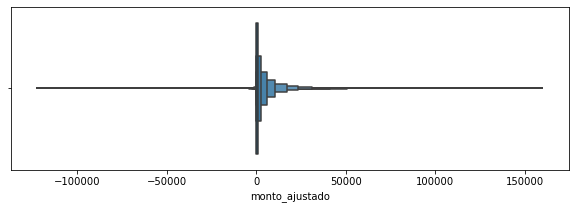

In [148]:
plt.figure(figsize=(10,3))
sns.boxenplot(data=df, x='monto_ajustado')

In [149]:
df['monto_ajustado'].describe().round(2)

count    4092077.00
mean        1537.20
std         4537.14
min      -123027.27
25%           59.55
50%          251.70
75%         1158.60
max       160281.96
Name: monto_ajustado, dtype: float64

In [150]:
print('0.5% <', df['monto_ajustado'].quantile(.005))
print('1% <', df['monto_ajustado'].quantile(.01))
print('5% <', df['monto_ajustado'].quantile(.05))
print('10% <', df['monto_ajustado'].quantile(.1))

0.5% < -747.38
1% < -269.26
5% < -0.19
10% < 5.46


In [151]:
print('10% >', df['monto_ajustado'].quantile(.90))
print('5% >', df['monto_ajustado'].quantile(.95))
print('1% >', df['monto_ajustado'].quantile(.99))
print('0.5% >', df['monto_ajustado'].quantile(.995))
print('0.05% >', df['monto_ajustado'].quantile(.9995))

10% > 3598.25
5% > 7128.219999999999
1% > 21062.63
0.5% > 28033.49
0.05% > 64710.09


Observamos que existe una muy baja probabilidad de que un cliente tenga consumos mayores a 64710 pesos, por lo que decidimos eliminar outliers por la derecha de ese valor.

Al existir consumos negativos que se corresponden (cancelan) con otros positivos, tomamos la decisión de eliminar outliers negativos usando el mismo limite con el que eliminamos outliers en el lado derecho.

In [152]:
df[df['monto_ajustado'] > 64710.09].shape

(1990, 41)

In [153]:
df[df['monto_ajustado'] < -64710.09].shape

(69, 41)

<AxesSubplot:xlabel='monto_ajustado'>

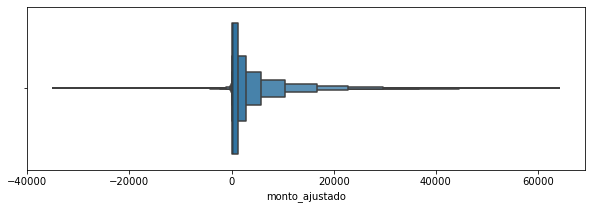

In [154]:
plt.figure(figsize=(10,3))
sns.boxenplot(data=df[(df['monto_ajustado'] < 64710.09) & (df['monto_ajustado'] > -64710.09)], x='monto_ajustado')

##### Valores atípicos en edad_cliente

<AxesSubplot:xlabel='edad_cliente'>

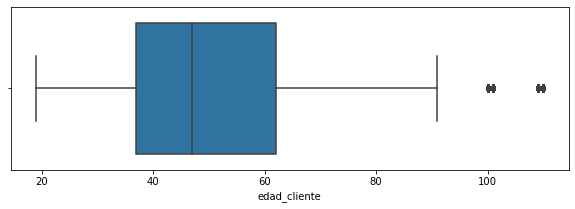

In [155]:
plt.figure(figsize=(10,3))
sns.boxplot(data=df, x='edad_cliente')

In [156]:
print('0.5% <', df['edad_cliente'].quantile(.005))
print('1% <', df['edad_cliente'].quantile(.01))
print('5% <', df['edad_cliente'].quantile(.05))
print('10% <', df['edad_cliente'].quantile(.1))
print('10% >', df['edad_cliente'].quantile(.90))
print('5% >', df['edad_cliente'].quantile(.95))
print('1% >', df['edad_cliente'].quantile(.99))
print('0.5% >', df['edad_cliente'].quantile(.995))

0.5% < 24.0
1% < 26.0
5% < 28.0
10% < 31.0
10% > 71.0
5% > 75.0
1% > 82.0
0.5% > 85.0


In [157]:
df[df['edad_cliente'] < 22].edad_cliente.value_counts()

21.0    4368
19.0    2553
20.0     828
Name: edad_cliente, dtype: int64

In [158]:
df[df['edad_cliente'] > 90].edad_cliente.value_counts()

109.0    3492
91.0     3448
110.0    1449
101.0     414
100.0     276
Name: edad_cliente, dtype: int64

Observamos que existen edades en ambos extremos con muy baja probabilidad de ocurrencia. Decidimos entonces, eliminar del dataset aquellas filas que correspondan a clientes mayores a 90 años y menores a 22.

Filas elminadas: 16828


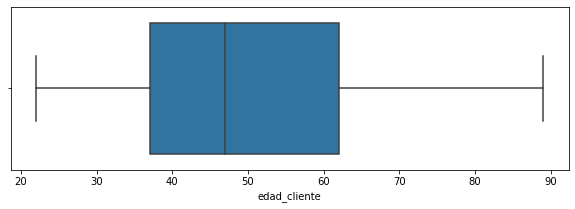

In [159]:
plt.figure(figsize=(10,3))
sns.boxplot(data=df[(df['edad_cliente'] >= 22) & (df['edad_cliente'] <= 90)], x='edad_cliente')
print('Filas elminadas:', len(df[(df['edad_cliente'] < 22) | (df['edad_cliente'] > 90)]))

##### Valores atípicos en antig_cliente

<AxesSubplot:xlabel='antig_cliente'>

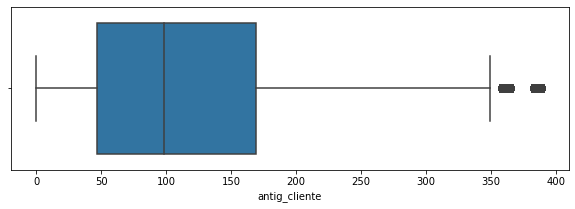

In [160]:
plt.figure(figsize=(10,3))
sns.boxplot(data=df, x='antig_cliente')

In [161]:
# 400 corresponderia a unos 33 años de antigüedad

print('10% >', df['antig_cliente'].quantile(.90))
print('5% >', df['antig_cliente'].quantile(.95))
print('1% >', df['antig_cliente'].quantile(.99))
print('0.5% >', df['antig_cliente'].quantile(.995))

10% > 241.0
5% > 269.0
1% > 288.0
0.5% > 304.0


In [162]:
df[df['antig_cliente'] > 360].antig_cliente.value_counts()

387    828
382    753
362    552
364    552
383    483
363    483
386    414
365    414
366    345
385    345
361    345
390    276
389    276
388    276
381    273
384    265
Name: antig_cliente, dtype: int64

Observamos que existen cuentas con antigüedad en el extremo derecho con muy baja probabilidad de ocurrencia. Decidimos entonces, eliminar del dataset aquellas filas que correspondan a clientes con antigüedad mayor a 360.

Filas elminadas: 6880


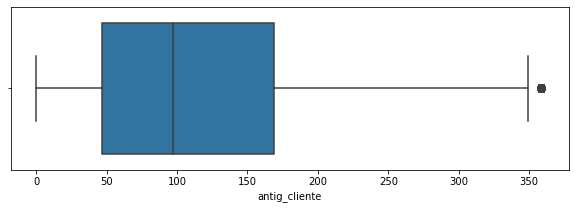

In [163]:
plt.figure(figsize=(10,3))
sns.boxplot(data=df[df['antig_cliente'] <= 360], x='antig_cliente')
print('Filas elminadas:', len(df[df['antig_cliente'] > 360]))


#### Variables categoricas (Reagrupación)

##### Producto Naranja

##### Estado Civil

In [164]:
df.estado_civil_descripcion.value_counts()

Solteroa               1984042
Casadoa                1565271
Divorciadoa             158427
Viudoa                  148689
Concubinoa               88864
Separacion de hecho      85429
Sin Datos                57077
Novioa                    4278
Name: estado_civil_descripcion, dtype: int64

Observamos que existe una alta frecuencia en las categorías Solteros y Casados, perdiendo representativadad en el resto de los estados civiles, por lo cual decidimos agrupar a la mismas en una misma categoría.

In [165]:
soltero = ['Solteroa']
casado = ['Casadoa']
otros = ['Divorciadoa','Viudoa','Concubinoa','Separacion de hecho','Novioa']
sin_datos = ['Sin Datos']

df.loc[df['estado_civil_descripcion'].str.contains('|'.join(soltero)),'estado_civil_cat'] = 'Soltero'
df.loc[df['estado_civil_descripcion'].str.contains('|'.join(casado)),'estado_civil_cat'] = 'Casado'
df.loc[df['estado_civil_descripcion'].str.contains('|'.join(otros)),'estado_civil_cat'] = 'Otros'
df.loc[df['estado_civil_descripcion'].str.contains('|'.join(sin_datos)),'estado_civil_cat'] = 'Sin_datos'

In [166]:
df.estado_civil_cat.value_counts()

Soltero      1984042
Casado       1565271
Otros         485687
Sin_datos      57077
Name: estado_civil_cat, dtype: int64

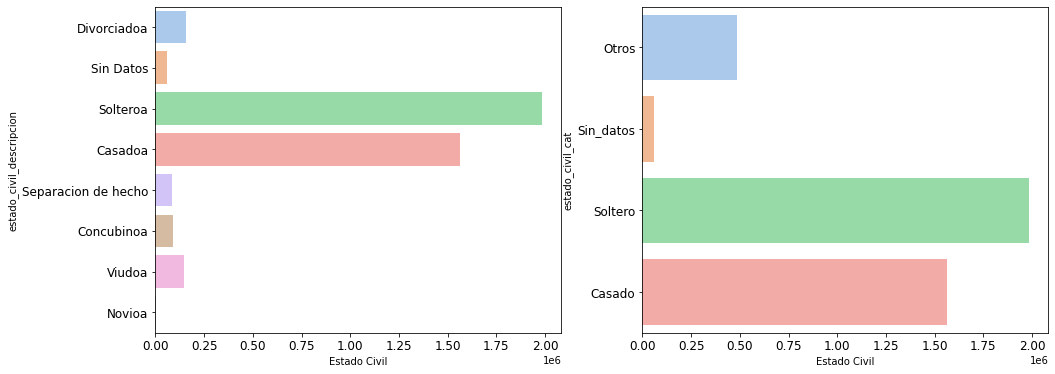

In [167]:
fig, axes = plt.subplots(ncols=2, figsize=(16,6))
g = sns.countplot(y=df.estado_civil_descripcion, ax=axes[0],palette="pastel")
g =  sns.countplot(y=df.estado_civil_cat, ax=axes[1],palette="pastel")

for ax in axes:
    ax.tick_params(labelsize=12)
    ax.set_xlabel("Estado Civil")

##### Provincias por Regiones

In [168]:
df[['provincia']].groupby(by=['provincia']).size()\
                .to_frame()\
                .reset_index(level=['provincia'])\
                .rename(columns = {0:'Cantidad_Transacciones'})\
                .sort_values(by='Cantidad_Transacciones',ascending=False)

,provincia,Cantidad_Transacciones
5,CORDOBA,795138
0,BUENOS AIRES,653412
20,SANTA FE,299497
24,TUCUMAN,289832
12,MENDOZA,275584
4,CHUBUT,168190
3,CHACO,153202
6,CORRIENTES,152523
1,CAPITAL FEDERAL,128941
16,SALTA,122984


Viendo las frecuencias por provincias, vamos a recategorizar sobre una nueva columna, las provincias por regiones.

In [169]:
dic_region = {'REGION NOROESTE': ['JUJUY','SALTA','TUCUMAN','CATAMARCA','SGO DEL ESTERO'],
              'REGION NORDESTE': ['CHACO','FORMOSA','CORRIENTES','MISIONES'], 
              'REGION PAMPEANA': ['CORDOBA','BUENOS AIRES','CAPITAL FEDERAL','ENTRE RIOS','LA PAMPA','SANTA FE'], 
              'REGION CUYO': ['SAN JUAN','SAN LUIS','LA RIOJA','MENDOZA'], 
              'REGION PATAGONIA': ['SANTA CRUZ','TIERRA DEL FUEGO','RIO NEGRO','NEUQUEN','CHUBUT'],
              'SIN DATOS': ['Sin Datos']}

df['region']= df['provincia']
for i in dic_region:
    df['region'] = df['region'].replace(dic_region[i], i)
df.head()

,dni_titular_movimiento,moneda_movimiento,id_comercio_movimiento,nombre_comercio_histo,numero_cupon_movimiento,debito_credito_movimiento,producto_naranja_movimiento,codigo_empresa_movimiento,tipo_producto_tarjeta_movimiento,plan_movimiento,fecha_vto_cupon_movimiento,fecha_presentacion_movimiento,fecha_cupon_movimiento,monto_compra_movimiento,importe_cuota_movimiento,interes_movimiento,cargo_adm_seguro_movimiento,cargo_otorgamiento_movimiento,cargo_seguro_vida_movimiento,cargo_administrativo_movimiento,seleccionado_ng,codigo_contable_movimiento,local_venta_producto,marca_debito_automatico,id_comercio_otras_marcas_movimiento,estado_civil_descripcion,sexo_descripcion,provincia,ciudad,domicilio_codigo_postal,fecha_de_ingreso_histo,cargo_descripcion_histo,nivel_estudio_descripcion_histo,rel_vivienda_descripcion_histo,anio_mes_cupon,monto_ajustado,nombre_comercio_concat,cargo_sector_desc_hist,edad_cliente,antig_cliente,comercio_cat,estado_civil_cat,region
0,0001686b52949b5461ffcbc766687e45031,0,020099784,INTERES POR MORA US,200813,0,PL,1,0,1,2020-09-10,2020-08-25,2020-08-25,6.24,6.24,0.0,0.0,0.0,0.0,0.0,0,281,20099784,0,0,Divorciadoa,Hombre,BUENOS AIRES,LA TABLADA,1766,2012-12-11,EMPDE COMERCIO,SECUNDARIOS,Propia,202008,5.52,INTERES POR MORA US,Sector_Empleado_Comercio,61.0,92,0,Otros,REGION PAMPEANA
1,000220fa96ec5af89817894033f8099c547,0,020099784,INTERES POR MORA US,200813,0,PL,1,0,1,2020-09-10,2020-08-25,2020-08-25,17.73,17.73,0.0,0.0,0.0,0.0,0.0,0,281,20099784,0,0,Sin Datos,Mujer,MENDOZA,VANVA DE GUAYMALLEN,5521,2020-06-10,SIN DATOS,SECUNDARIOS,Propia,202008,15.68,INTERES POR MORA US,Sector_Sin_Datos,29.0,2,0,Sin_datos,REGION CUYO
2,0002be202de47dfae9cc2304d91161be595,0,020099784,INTERES POR MORA US,200813,0,PL,1,0,1,2020-09-10,2020-08-25,2020-08-25,6.18,6.18,0.0,0.0,0.0,0.0,0.0,0,281,20099784,0,0,Solteroa,Mujer,BUENOS AIRES,SANTA TERESITA,7107,2012-09-13,SIN DATOS,PRIMARIOS,Otros,202008,5.46,INTERES POR MORA US,Sector_Sin_Datos,28.0,95,0,Soltero,REGION PAMPEANA
3,000e137d0af42e193be1ff670c00d4d1506,0,020099784,INTERES POR MORA US,200813,0,PL,1,0,1,2020-09-10,2020-08-25,2020-08-25,2.83,2.83,0.0,0.0,0.0,0.0,0.0,0,281,20099784,0,0,Solteroa,Hombre,SANTA FE,SAN LORENZO,2200,2008-01-15,EMPDE COMERCIO,SECUNDARIOS,Propia,202008,2.50,INTERES POR MORA US,Sector_Empleado_Comercio,40.0,151,0,Soltero,REGION PAMPEANA
4,0009d010e4faf69552a814a33832b185877,0,020099784,INTERES POR MORA US,200813,0,PL,1,0,1,2020-09-10,2020-08-25,2020-08-25,2.38,2.38,0.0,0.0,0.0,0.0,0.0,0,281,20099784,0,0,Solteroa,Mujer,CAPITAL FEDERAL,CIUDAD AUTONOMA DE BUENOS AIRES,1019,2013-06-06,EMPDE COMERCIO,UNIVERSITARIOS,Alquilada,202008,2.10,INTERES POR MORA US,Sector_Empleado_Comercio,36.0,87,0,Soltero,REGION PAMPEANA


In [170]:
df[['region']].groupby(by=['region']).size()

region
REGION CUYO          498724
REGION NORDESTE      456101
REGION NOROESTE      696105
REGION PAMPEANA     2014316
REGION PATAGONIA     393401
SIN DATOS             33430
dtype: int64

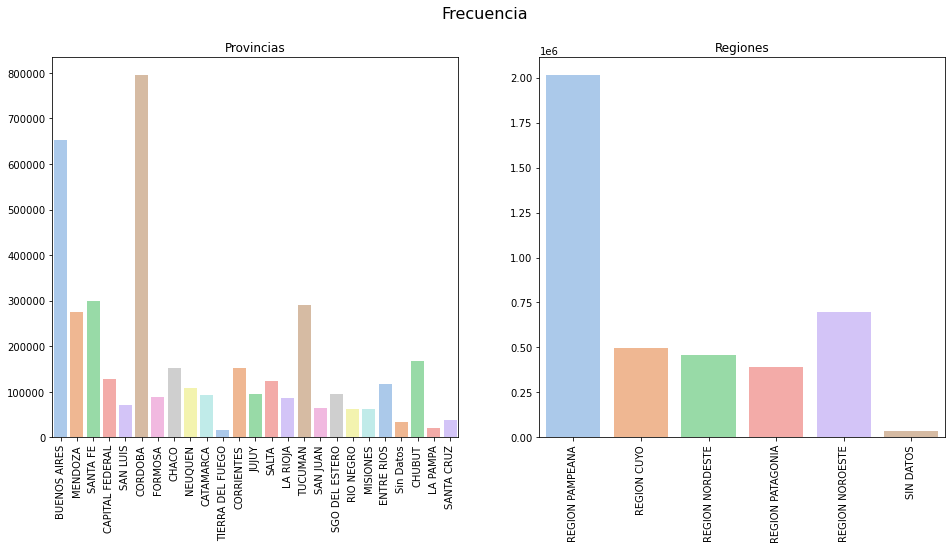

In [171]:
fig, axes = plt.subplots(1, 2,figsize=(16, 7))

sns.countplot(data=df, x='provincia', ax=axes[0], palette='pastel')
axes[0].title.set_text('Provincias')
axes[0].tick_params('x', rotation=90)
sns.countplot(data=df, x='region', ax=axes[1], palette='pastel')
axes[1].title.set_text('Regiones')
axes[1].tick_params('x', rotation=90)

axes[0].set_ylabel('')
axes[0].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_xlabel('')

fig.suptitle('Frecuencia', fontsize=16)
plt.show()

#### Fechas

Veremos las relaciones entre las distintas columnas de fecha para ver si podemos descartar algunas.

Text(0.5, 1.0, 'Histograma de frecuencia para fecha de cupón')

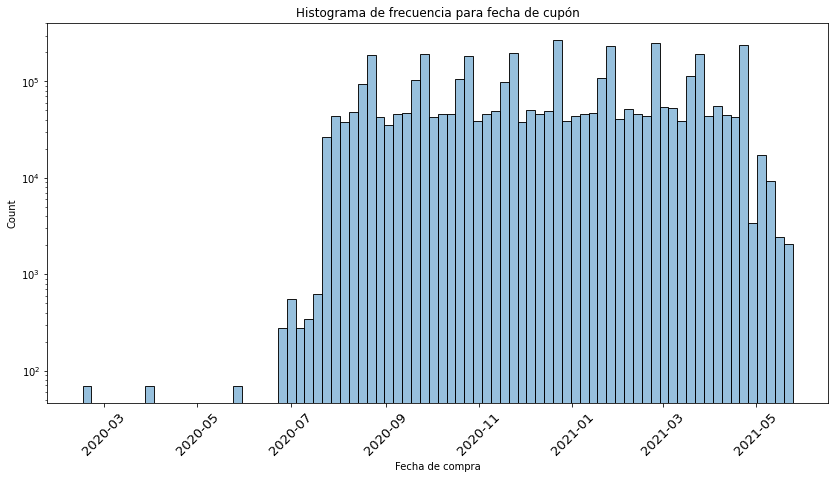

In [172]:
fecha = 'fecha_cupon_movimiento'

fig, ax = plt.subplots(figsize=(14,7))
ax.tick_params(axis='x',rotation = 45,labelsize = 13)
ax.set_xlabel("Fecha de compra")
ax.set_yscale("log")
sns.histplot(data=df, x=fecha, bins=80, color="#3182bd", alpha=0.5)
ax.set_title('Histograma de frecuencia para fecha de cupón')

In [173]:
print('Cantidad de casos antes de Abril 2020:', len(df[df['fecha_cupon_movimiento'] < pd.to_datetime('2020-04-01')]))
print('Cantidad de casos antes de Mayo 2020:', len(df[df['fecha_cupon_movimiento'] < pd.to_datetime('2020-05-01')]))
print('Cantidad de casos antes de Junio 2020:', len(df[df['fecha_cupon_movimiento'] < pd.to_datetime('2020-06-01')]))
print('Cantidad de casos antes de Julio 2020:', len(df[df['fecha_cupon_movimiento'] < pd.to_datetime('2020-07-01')]))
print('Cantidad de casos antes de Agosto 2020:', len(df[df['fecha_cupon_movimiento'] < pd.to_datetime('2020-08-01')]))

Cantidad de casos antes de Abril 2020: 69
Cantidad de casos antes de Mayo 2020: 138
Cantidad de casos antes de Junio 2020: 207
Cantidad de casos antes de Julio 2020: 552
Cantidad de casos antes de Agosto 2020: 59281


In [174]:
print('Cantidad de casos despues de Abril 2021:', len(df[df['fecha_cupon_movimiento'] > pd.to_datetime('2021-04-01')]))
print('Cantidad de casos despues de Mayo 2021:', len(df[df['fecha_cupon_movimiento'] > pd.to_datetime('2021-05-01')]))
print('Cantidad de casos despues de Junio 2021:', len(df[df['fecha_cupon_movimiento'] > pd.to_datetime('2021-06-01')]))

Cantidad de casos despues de Abril 2021: 420667
Cantidad de casos despues de Mayo 2021: 30973
Cantidad de casos despues de Junio 2021: 0


Desde Agosto del 2020, la cantidad de transacciones aumenta significativamente en comparación con meses anteriores. Decidimos conservar solo los meses donde haya suficiente representacion de casos.

Haciendo un cálculo similar a los ultimos meses analizados, vemos que Mayo y Abril del 2021 están bien representados, por lo que se decide conservarlos.

In [175]:
df[df['fecha_cupon_movimiento'] < pd.to_datetime('2020-07-01')]

,dni_titular_movimiento,moneda_movimiento,id_comercio_movimiento,nombre_comercio_histo,numero_cupon_movimiento,debito_credito_movimiento,producto_naranja_movimiento,codigo_empresa_movimiento,tipo_producto_tarjeta_movimiento,plan_movimiento,fecha_vto_cupon_movimiento,fecha_presentacion_movimiento,fecha_cupon_movimiento,monto_compra_movimiento,importe_cuota_movimiento,interes_movimiento,cargo_adm_seguro_movimiento,cargo_otorgamiento_movimiento,cargo_seguro_vida_movimiento,cargo_administrativo_movimiento,seleccionado_ng,codigo_contable_movimiento,local_venta_producto,marca_debito_automatico,id_comercio_otras_marcas_movimiento,estado_civil_descripcion,sexo_descripcion,provincia,ciudad,domicilio_codigo_postal,fecha_de_ingreso_histo,cargo_descripcion_histo,nivel_estudio_descripcion_histo,rel_vivienda_descripcion_histo,anio_mes_cupon,monto_ajustado,nombre_comercio_concat,cargo_sector_desc_hist,edad_cliente,antig_cliente,comercio_cat,estado_civil_cat,region
880997,0005e599adf902c15aba4890e5c21dbf100,0,020099902,COMISION POR MANTENIMDE CTA,999990,1,PL,1,0,1,2020-07-10,2020-06-25,2020-06-25,-301.29,-602.58,0.0,0.0,0.0,0.0,0.0,0,2463,20099902,0,0,Casadoa,Mujer,BUENOS AIRES,GREGORIO DE LAFERRERE,1757,2017-10-25,SIN DATOS,SECUNDARIOS,Propia,202006,-277.69,COMISION POR MANTENIMDE CTA,Sector_Sin_Datos,71.0,32,0,Casado,REGION PAMPEANA
880998,0005e599adf902c15aba4890e5c21dbf100,0,020099902,COMISION POR MANTENIMDE CTA,999990,1,PL,1,0,1,2020-07-10,2020-06-25,2020-06-25,-301.29,-602.58,0.0,0.0,0.0,0.0,0.0,0,2463,20099902,0,0,Casadoa,Mujer,BUENOS AIRES,GREGORIO DE LAFERRERE,1757,2017-10-25,SIN DATOS,SECUNDARIOS,Propia,202006,-277.69,COMISION POR MANTENIMDE CTA,Sector_Sin_Datos,71.0,32,0,Casado,REGION PAMPEANA
880999,0005e599adf902c15aba4890e5c21dbf100,0,020099902,COMISION POR MANTENIMDE CTA,999990,1,PL,1,0,1,2020-07-10,2020-06-25,2020-06-25,-301.29,-602.58,0.0,0.0,0.0,0.0,0.0,0,2463,20099902,0,0,Casadoa,Mujer,BUENOS AIRES,GREGORIO DE LAFERRERE,1757,2017-10-25,SIN DATOS,SECUNDARIOS,Propia,202006,-277.69,COMISION POR MANTENIMDE CTA,Sector_Sin_Datos,71.0,32,0,Casado,REGION PAMPEANA
881000,0005e599adf902c15aba4890e5c21dbf100,0,020099902,COMISION POR MANTENIMDE CTA,999990,1,PL,1,0,1,2020-07-10,2020-06-25,2020-06-25,-301.29,-602.58,0.0,0.0,0.0,0.0,0.0,0,2463,20099902,0,0,Casadoa,Mujer,BUENOS AIRES,GREGORIO DE LAFERRERE,1757,2017-10-25,SIN DATOS,SECUNDARIOS,Propia,202006,-277.69,COMISION POR MANTENIMDE CTA,Sector_Sin_Datos,71.0,32,0,Casado,REGION PAMPEANA
881001,0005e599adf902c15aba4890e5c21dbf100,0,020099902,COMISION POR MANTENIMDE CTA,999990,1,PL,1,0,1,2020-07-10,2020-06-25,2020-06-25,-301.29,-602.58,0.0,0.0,0.0,0.0,0.0,0,2463,20099902,0,0,Casadoa,Mujer,BUENOS AIRES,GREGORIO DE LAFERRERE,1757,2017-10-25,SIN DATOS,SECUNDARIOS,Propia,202006,-277.69,COMISION POR MANTENIMDE CTA,Sector_Sin_Datos,71.0,32,0,Casado,REGION PAMPEANA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4092072,000986998f686d538f893956e736fedf611,3,350071053,20 DE MAYO SRL,70,0,PL,1,0,1,2021-01-10,2020-12-02,2020-02-16,1040.00,1040.00,0.0,0.0,0.0,0.0,0.0,0,387,350071053,0,0,Casadoa,Hombre,LA RIOJA,LA RIOJA,5300,1998-05-26,OPERARIO,SECUNDARIOS,Propia,202002,1040.00,20 DE MAYO SRL,Sector_Operativo,45.0,261,3,Casado,REGION CUYO
4092073,000986998f686d538f893956e736fedf611,3,350071053,20 DE MAYO SRL,70,0,PL,1,0,1,2021-01-10,2020-12-02,2020-02-16,1040.00,1040.00,0.0,0.0,0.0,0.0,0.0,0,387,350071053,0,0,Casadoa,Hombre,LA RIOJA,LA RIOJA,5300,1998-05-26,OPERARIO,SECUNDARIOS,Propia,202002,1040.00,20 DE MAYO SRL,Sector_Operativo,45.0,261,3,Casado,REGION CUYO
4092074,000986998f686d538f893956e736fedf611,3,350071053,20 DE MAYO SRL,70,0,PL,1,0,1,2021-01-10,2020-12-02,2020-02-16,1040.00,1040.00,0.0,0.0,0.0,0.0,0.0,0,387,350071053,0,0,Casadoa,Hombre,LA RIOJA,LA RIOJA,5300,1998-05-26,OPERARIO,SECUNDARIOS,Propia,202002,1040.00,20 DE MAYO SRL,Sector_Operativo,45.0,261,3,Casado,REG

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


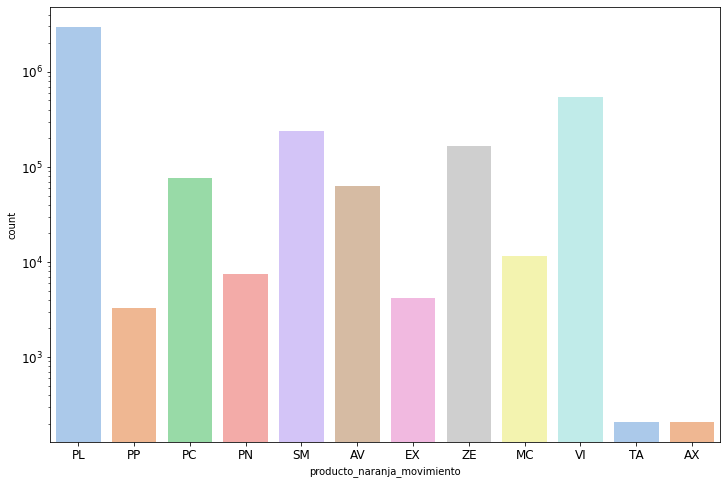

In [176]:
fig, ax = plt.subplots(figsize=(12,8))
sns.countplot(df['producto_naranja_movimiento'], palette="pastel")
ax.tick_params(labelsize=12)
ax.set_yscale('log')

In [177]:
df_prod = df['producto_naranja_movimiento'].value_counts().to_frame().reset_index().rename(
                                    {'index':'producto_naranja_movimiento',
                                     'producto_naranja_movimiento':'frecuencia_pr'}, axis=1)

df_prod_dni = pd.DataFrame(df.groupby(['producto_naranja_movimiento'])['dni_titular_movimiento'].nunique() \
                            .sort_values(ascending=True)) \
                            .reset_index()

df_prod_dni = df_prod_dni.merge(df_prod, on='producto_naranja_movimiento', how='inner')
df_prod_dni

,producto_naranja_movimiento,dni_titular_movimiento,frecuencia_pr
0,AX,2,207
1,TA,2,207
2,EX,4,4140
3,MC,20,11661
4,PP,25,3276
5,PN,59,7521
6,AV,116,62583
7,PC,281,76522
8,SM,388,239775
9,VI,441,546687


Productos:

* PL: Plan largo 
* ZE: Zeta
* VI: Visa
* SM: Mensajes de texto a celulares
* PC: Plan de Cuotas
* AV: Revista Convivimos
* PN: Prestamos Personales PN
* PP: Plan de Pago Propuesto
* MC: MasterCard
* EX: Extraccion de Cajeros Nacionales
* TA: Transferencia Naranja Arg.
* AX: American Express

Eliminamos del dataset aquellas transacciones que corresponden a productos con importes constantes. No sufren modificaciones en el tiempo por lo tanto no es necesario predecir el monto.

Estas serian: 

- SM
- AV

#### Elimnacion de outliers

In [178]:
df = df[(df['monto_ajustado'] > -64710.09) & (df['monto_ajustado'] < 64710.09)]

df = df[(df['edad_cliente'] <= 90) & (df['edad_cliente'] >= 22)]

df = df[df['antig_cliente'] <= 360]

df = df[df['fecha_cupon_movimiento'] > pd.to_datetime('2020-07-01')]

df = df[~df['producto_naranja_movimiento'].isin(['AV','SM'])]

In [179]:
df.shape

(3765953, 43)

### 3.3 Normalización de antiguedad y/o monto_compra_movimiento

In [180]:
from sklearn.preprocessing import Normalizer

x_test = df[["monto_ajustado","antig_cliente"]].values #returns a numpy array
transformer = Normalizer(norm='l1').fit(x_test)
x_norm = transformer.transform(x_test)
dff = pd.DataFrame(x_norm).rename(columns={0: 'monto_ajustado', 1: 'antig_cliente'})

In [181]:
dff

,monto_ajustado,antig_cliente
0,0.056604,0.943396
1,0.886878,0.113122
2,0.054350,0.945650
3,0.016287,0.983713
4,0.023569,0.976431
...,...,...
3765948,0.988732,0.011268
3765949,0.465098,0.534902
3765950,0.988732,0.011268
3765951,0.465098,0.534902


In [182]:
#scaled_df = pd.DataFrame(
colums_norm = ["monto_compra_movimiento","antig_cliente"] 
df_scaled = pd.DataFrame(preprocessing.StandardScaler().fit_transform(df[colums_norm])).rename(columns={'0': 'monto_compra_movimiento', '1': 'antig_cliente'})
df_scaled 

,0,1
0,-0.383168,-0.265924
1,-0.381018,-1.404908
2,-0.383179,-0.227957
3,-0.383806,0.480744
4,-0.383890,-0.329200
...,...,...
3765948,2.989858,0.341535
3765949,-0.350899,0.341535
3765950,2.989858,0.341535
3765951,-0.350899,0.341535


In [183]:
monto = df.monto_ajustado.values.copy()
antig = df.antig_cliente.values.copy()
monto_norm = dff.monto_ajustado
antig_norm = dff.antig_cliente

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Monto normalizado')

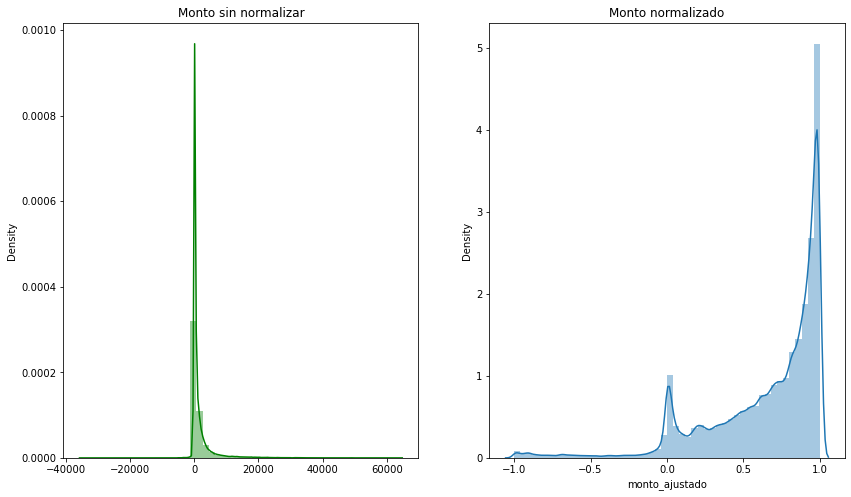

In [184]:
fig, ax=plt.subplots(1,2, figsize=(14,8))
sns.distplot(monto,ax=ax[0],color='Green')
ax[0].set_title("Monto sin normalizar")
sns.distplot(monto_norm, ax=ax[1])
ax[1].set_title("Monto normalizado")

Podemos observar que la distribución de la variable transformada difiere mucho de la normal. Los consumos de los clientes no necesariamente se van a distribuir de manera normal. Uno de los objetivos de esta mentoria es encontrar clusters de consumo, por lo cual partimos de la premisa de que no vamos a tener una distribucion normal donde la media represente de manera significativa a todos los clientes. Por lo tanto transformar esta distribucion a una normal no nos parece conveniente.

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Antiguedad normalizada')

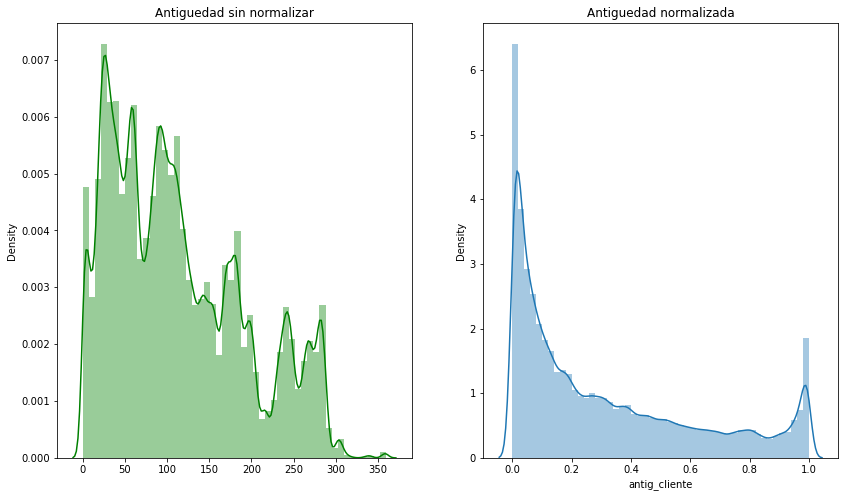

In [185]:
fig, ax=plt.subplots(1,2, figsize=(14,8))
sns.distplot(antig,ax=ax[0],color='Green')
ax[0].set_title("Antiguedad sin normalizar")
sns.distplot(antig_norm, ax=ax[1])
ax[1].set_title("Antiguedad normalizada")

Observamos que la distribución que resulta de esta transformacion no se parece a una normal. Por lo tanto, concluimos que se pierde mucha información y las ganancias obtenidas son bajas. Decidimos entonces, conservar la distribución original de esta variable.

### 3.4.1 Seleccion de columnas a utilizar

#### Calculos de correlaciones numericas

In [186]:
print('fecha_cupon vs fecha_presentacion:')
df["fecha_cupon_movimiento"].dt.date.corr(
    df["fecha_presentacion_movimiento"].dt.date, method = 'spearman', min_periods = 1)

fecha_cupon vs fecha_presentacion:


0.9986858985051322

In [187]:
print('fecha_cupon vs fecha_vto:')
df["fecha_cupon_movimiento"].dt.date.corr(
    df['fecha_vto_cupon_movimiento'].dt.date, method = 'spearman', min_periods = 1)

fecha_cupon vs fecha_vto:


0.9893333206453957

In [188]:
df[["monto_compra_movimiento", "importe_cuota_movimiento"]].corr()

,monto_compra_movimiento,importe_cuota_movimiento
monto_compra_movimiento,1.000000,0.992688
importe_cuota_movimiento,0.992688,1.000000


In [189]:
df[["id_comercio_otras_marcas_movimiento", "id_comercio_movimiento"]].corr()

,id_comercio_otras_marcas_movimiento
id_comercio_otras_marcas_movimiento,1.0


In [190]:
df[["local_venta_producto", "id_comercio_movimiento"]].corr()

,local_venta_producto
local_venta_producto,1.0


In [191]:
df.groupby(['nivel_estudio_descripcion_histo'])['monto_ajustado'].describe().round(2).sort_values(by="nivel_estudio_descripcion_histo", ascending=True)

,count,mean,std,min,25%,50%,75%,max
nivel_estudio_descripcion_histo,,,,,,,,
PRIMARIOS,903943.0,1570.89,4180.44,-20778.07,72.99,254.33,1294.22,64203.01
SECUNDARIOS,2142509.0,1604.09,4187.26,-35117.69,86.28,271.37,1268.71,62261.25
TERCIARIOS,442157.0,1698.57,4155.05,-24125.31,108.28,332.18,1534.52,63934.11
UNIVERSITARIOS,277344.0,1660.13,3923.79,-12454.50,119.13,322.39,1440.20,58939.82


In [192]:
df.groupby(['rel_vivienda_descripcion_histo'])['monto_ajustado'].describe().round(2).sort_values(by="rel_vivienda_descripcion_histo", ascending=True)

,count,mean,std,min,25%,50%,75%,max
rel_vivienda_descripcion_histo,,,,,,,,
Alquilada,131627.0,1584.78,4094.15,-12997.97,81.43,301.05,1358.70,57272.62
De familiar,309467.0,1757.52,4354.98,-35117.69,123.78,345.41,1671.76,60210.74
Otros,322880.0,1616.05,3900.48,-4278.96,77.39,260.73,1500.06,55161.54
Propia,3001979.0,1596.93,4173.01,-25775.87,85.86,266.39,1263.00,64203.01


#### Analisis descriptivo por columna

Algunas columnas se eliminaron en analisis anteriores. Procedemos a seleccionar las columnas que mejor nos ayudaran a predecir la próxima compra

* **dni_titular_movimiento: Se conserva por ser ID único de cliente**
* moneda_movimiento: Se descarta ya que se va a utilizar monto_ajustada, que tiene todos los montos en pesos
* id_comercio_movimiento: Se descarta porque conservamos comercio_cat que surge a partir de esta misma variable
* nombre_comercio_histo: Se descarta por usar comercio_cat
* numero_cupon_movimiento: Se descarta por no aportar informacion util a la predicción de la compra
* debito_credito_movimiento: Solo permite diferenciar movimientos positivos de negativos, informacion presente en la variable monto.
* **producto_naranja_movimiento: Se conserva**
* codigo_empresa_movimiento: Se descarta por no aportar informacion util a la predicción de la compra
* **tipo_producto_tarjeta_movimiento: Se conserva**
* plan_movimiento: Se descarta por no aportar informacion util a la predicción de la compra
* fecha_cupon_movimiento: Se descarta para conservad anio_mes_cupon y asi poder agrupar los movimientos de los clientes mensualmente.
* monto_compra_movimiento: Se descarta, ya que se conserva monto_ajustado, que es el resultado de su transformación
* importe_cuota_movimiento: Se descarta por su fuerte correlación con monto_compra_movimiento
* interes_movimiento: Se descarta por su falta de datos significativos
* cargo_adm_seguro_movimiento, cargo_otorgamiento_movimiento, cargo_seguro_vida_movimiento, cargo_administrativo_movimiento: Se descartan por tener mayoria de datos en 0.
* seleccionado_ng: Se descarta por no representar nada significativo
* codigo_contable_movimiento: Se descarta por su baja interpretabilidad
* local_venta_producto: Se descarta por aportar la misma información que id_comercio_movimiento
* marca_debito_automatico: Se descarta por no aportar informacion util a la predicción de la compra
* id_comercio_otras_marcas_movimiento: Se descarta por tener mayoria de datos en 0 y una correlación fuerte con id_comercio
* estado_civil_descripcion: Se descarta por recategorización
* **sexo_descripcion: Se conserva**  
* provincia: Se descarta por recategorizacion en regiones
* ciudad: Se descarta para tener un analisis geografico limitado hasta regiones
* domicilio_codigo_postal: Se descarta para tener un analisis geografico limitado hasta regiones
* fecha_de_ingreso_histo: Se descarta porque su único objetivo era calcular la antigüedad del cliente
* fecha_presentacion_movimiento: Se descarta por su fuerte correlación con fecha_cupon_movimiento
* fecha_vto_cupon_movimiento: Se descarta por su fuerte correlación con fecha_cupon_movimiento
* cargo_descripcion_histo: Se descarta por recategorizacion
* nivel_estudio_descripcion_histo: Se descarta por tener distribuciones parecidas para cada categoría
* rel_vivienda_descripcion_histo: Se descarta por tener distribuciones parecidas para cada categoría

In [193]:
df_final = df[['dni_titular_movimiento', 'producto_naranja_movimiento', 'tipo_producto_tarjeta_movimiento',
               'anio_mes_cupon', 'sexo_descripcion', 'monto_ajustado',
               'cargo_sector_desc_hist', 'edad_cliente', 'antig_cliente', 'comercio_cat', 
               'estado_civil_cat', 'region']]

In [194]:
df_final.shape

(3765953, 12)

#### Reagrupamiento de transacciones por Cliente, Mes, Producto Naranja y Tipo de producto

In [195]:
#df['antig_cliente']= ((df['fecha_cupon_movimiento'] - df['fecha_de_ingreso_histo'])/np.timedelta64(1, 'M'))
#df['antig_cliente']= df.antig_cliente.apply(np.ceil).apply(int)

In [196]:
cols_group = ['dni_titular_movimiento', 'anio_mes_cupon', 'sexo_descripcion',
               'cargo_sector_desc_hist', 'estado_civil_cat', 'region', 'comercio_cat',
                 'producto_naranja_movimiento', 'tipo_producto_tarjeta_movimiento']

df_final_rg = df_final.groupby(cols_group).agg({'monto_ajustado':'sum', 
                         'edad_cliente':'max', 
                         'antig_cliente':'max'}).reset_index()

df_final_rg

,dni_titular_movimiento,anio_mes_cupon,sexo_descripcion,cargo_sector_desc_hist,estado_civil_cat,region,comercio_cat,producto_naranja_movimiento,tipo_producto_tarjeta_movimiento,monto_ajustado,edad_cliente,antig_cliente
0,000000b5aea2c9ea7cc155f6ebcef97f826,202008,Mujer,Sector_Sin_Datos,Soltero,REGION PAMPEANA,0,PL,0,-325.68,46.0,225
1,000000b5aea2c9ea7cc155f6ebcef97f826,202009,Mujer,Sector_Sin_Datos,Soltero,REGION PAMPEANA,0,PL,0,-318.09,47.0,226
2,000000b5aea2c9ea7cc155f6ebcef97f826,202010,Mujer,Sector_Sin_Datos,Soltero,REGION PAMPEANA,0,PL,0,-307.74,47.0,227
3,000000b5aea2c9ea7cc155f6ebcef97f826,202011,Mujer,Sector_Sin_Datos,Soltero,REGION PAMPEANA,0,PL,0,-299.46,47.0,228
4,000000b5aea2c9ea7cc155f6ebcef97f826,202012,Mujer,Sector_Sin_Datos,Soltero,REGION PAMPEANA,0,PL,0,-290.49,47.0,229
...,...,...,...,...,...,...,...,...,...,...,...,...
23203,000f0b73ebfa002a79a0642b82e87919904,202104,Mujer,Sector_Sin_Datos,Casado,REGION CUYO,0,PL,0,19956.87,64.0,24
23204,000f0b73ebfa002a79a0642b82e87919904,202104,Mujer,Sector_Sin_Datos,Casado,REGION CUYO,0,PL,3,61555.59,64.0,24
23205,000f0b73ebfa002a79a0642b82e87919904,202104,Mujer,Sector_Sin_Datos,Casado,REGION CUYO,0,ZE,3,96119.07,64.0,24
23206,000f0b73ebfa002a79a0642b82e87919904,202104,Mujer,Sector_Sin_Datos,Casado,REGION CUYO,2,PL,3,145677.63,64.0,24


### 3.4.2 Análisis del PCA

Primero se debe procesar las columnas antes de aplicar el PCA, es decir dejarlas en formato de matríz y estandarizarlas para el mejor uso del algoritmo.

In [197]:
colum_pca = ["monto_ajustado", "edad_cliente","antig_cliente"] 

In [198]:
df_pca = df_final_rg[colum_pca]

In [199]:
df_pca_stand = preprocessing.StandardScaler().fit_transform(df_pca)
df_pca_stand

array([[-0.53249376, -0.20233216,  1.48305941],
       [-0.53247832, -0.13499449,  1.49605834],
       [-0.53245727, -0.13499449,  1.50905726],
       ...,
       [-0.33632565,  1.0097458 , -1.12972476],
       [-0.2355238 ,  1.0097458 , -1.12972476],
       [-0.24218461,  1.0097458 , -1.11672583]])

In [200]:
pca2 = PCA(n_components=3)
pca2.fit(df_pca_stand)
proyected_features_2 = pca2.transform(df_pca_stand)
proyected_features_2.shape

(23208, 3)

In [201]:
explained_variance_2 = pca2.explained_variance_ratio_
explained_variance_2

array([0.46896494, 0.33139931, 0.19963574])

In [202]:
acc_variance_percent_2 = np.cumsum(np.round(explained_variance_2, decimals=4) * 100)
acc_variance_percent_2

array([ 46.9 ,  80.04, 100.  ])

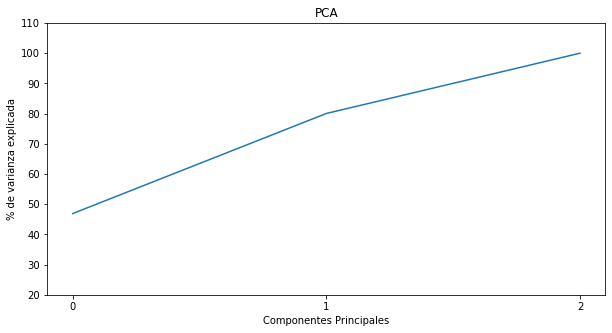

In [203]:
plt.figure(figsize=(10, 5))
plt.ylabel('% de varianza explicada')
plt.xlabel('Componentes Principales')
plt.title('PCA')
plt.ylim(20, 110)
plt.xticks(range(pca2.n_components))
plt.plot(acc_variance_percent_2)

Existen dos componentes principales que explican un 80.04% de la variabilidad de los datos.

In [204]:
df_pca_final = df_final_rg[colum_pca]
df_pca_final.loc[:,["pca1","pca2"]] = proyected_features_2[:,:2]
df_pca_final

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/pandas/core/indexing.py:659: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[k] = np.nan
/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


,monto_ajustado,edad_cliente,antig_cliente,pca1,pca2
0,-325.68,46.0,225,0.829899,-0.567124
1,-318.09,47.0,226,0.885993,-0.577546
2,-307.74,47.0,227,0.895144,-0.578143
3,-299.46,47.0,228,0.904295,-0.578743
4,-290.49,47.0,229,0.913446,-0.579343
...,...,...,...,...,...
23203,19956.87,64.0,24,-0.158297,-0.579022
23204,61555.59,64.0,24,-0.146730,-0.495411
23205,96119.07,64.0,24,-0.137119,-0.425941
23206,145677.63,64.0,24,-0.123339,-0.326332


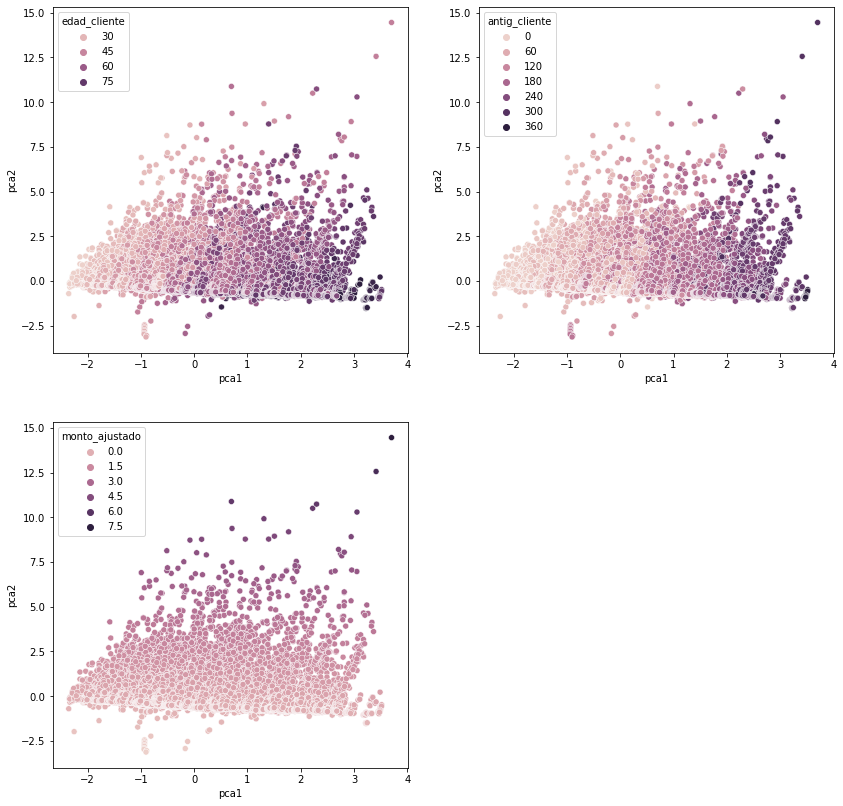

In [205]:
cols = ['edad_cliente', 'antig_cliente', 'monto_ajustado']
data = df_pca_final[cols + ['pca1', 'pca2']]
fig, axes = plt.subplots(2, 2, figsize=(14, 14))
sns.scatterplot(data=data, x='pca1', y='pca2',
                    hue='edad_cliente', ax=axes[0][0])  
sns.scatterplot(data=data, x='pca1', y='pca2',
                    hue='antig_cliente', ax=axes[0][1]) 
sns.scatterplot(data=data, x='pca1', y='pca2',
                    hue='monto_ajustado', ax=axes[1][0]) 
fig.delaxes(axes[1][1])

Sabemos que PCA es un metodo utilizado para reducir dimensionalidad. Aplica combinaciones lineales de las variables para obtener componentes principales que expliquen la variabilidad de los datos. 

En este caso, obtuvimos dos componentes principales que explican el 80.04% de la varianza. Al graficar estos componentes junto con los features originales, podemos observar lo siguiente:

- En los primeros dos graficos, el PCA1 parece aumentar conforme aumenta edad_cliente y antiguedad_cliente (de color violeta claro, a uno mas oscuro para valores mas altos de pca1). Por lo cual se podria concluir que PCA1 explica la variabilidad de los datos en funcion a estos features.  Sin embargo, pareciera haber algunas zonas donde el cambio no es gradual, sacandole continuidad al cambio en la variabilidad. 

- En el tercer grafico se puede observar que el comportamiento del feature monto_ajustado explica la variabilidad de los datos de una manera parecida a PCA2. La gradualidad de este cambio se ve de forma mas clara respecto a los graficos anteriores. 


Seria posible en base a esto, eliminar edad_cliente o antiguedad_cliente, ya que ambas son explicadas por el componente PCA1.

#### Union de las columnas resultantes de PCA

In [206]:
df_final_rg = df_final_rg.merge(df_pca_final[['pca1', 'pca2']], left_index=True, right_index=True)
df_final_rg.shape

(23208, 14)

### Codificación

In [207]:
# Transformacion de tipo_producto_tarjeta_movimiento a string

df_final_rg['tipo_producto_tarjeta_movimiento'] = df_final_rg['tipo_producto_tarjeta_movimiento'].astype(str)

In [208]:
df_final_rg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23208 entries, 0 to 23207
Data columns (total 14 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   dni_titular_movimiento            23208 non-null  object 
 1   anio_mes_cupon                    23208 non-null  int64  
 2   sexo_descripcion                  23208 non-null  object 
 3   cargo_sector_desc_hist            23208 non-null  object 
 4   estado_civil_cat                  23208 non-null  object 
 5   region                            23208 non-null  object 
 6   comercio_cat                      23208 non-null  object 
 7   producto_naranja_movimiento       23208 non-null  object 
 8   tipo_producto_tarjeta_movimiento  23208 non-null  object 
 9   monto_ajustado                    23208 non-null  float64
 10  edad_cliente                      23208 non-null  float64
 11  antig_cliente                     23208 non-null  int64  
 12  pca1

In [209]:
# A efectos de corroborar la cantidad de columnas de nuestra matriz

print("dni_titular_movimiento", df_final_rg.dni_titular_movimiento.nunique())
print("sexo_descripcion", df_final_rg.sexo_descripcion.nunique())
print("cargo_sector_desc_hist", df_final_rg.cargo_sector_desc_hist.nunique())
print("estado_civil_cat", df_final_rg.estado_civil_cat.nunique())
print("region", df_final_rg.region.nunique())
print("comercio_cat", df_final_rg.comercio_cat.nunique())
print("producto_naranja_movimiento", df_final_rg.producto_naranja_movimiento.nunique())
print("tipo_producto_tarjeta_movimiento", df_final_rg.tipo_producto_tarjeta_movimiento.nunique())

dni_titular_movimiento 836
sexo_descripcion 3
cargo_sector_desc_hist 8
estado_civil_cat 4
region 6
comercio_cat 10
producto_naranja_movimiento 10
tipo_producto_tarjeta_movimiento 6


In [210]:
from sklearn.preprocessing import OneHotEncoder

new_columns = []

categorical_cols = ['dni_titular_movimiento', 'sexo_descripcion',
         'cargo_sector_desc_hist', 'estado_civil_cat', 'region', 'comercio_cat',
         'producto_naranja_movimiento', 'tipo_producto_tarjeta_movimiento']

encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
X_cat = encoder.fit_transform(df_final_rg[categorical_cols])
for col, col_values in zip(categorical_cols, encoder.categories_):
    for col_value in col_values:
        new_columns.append('{}={}'.format(col, col_value))
#print("Matrix has shape {}, with columns: {}".format(X_cat.shape, new_columns))

In [211]:
numerical_cols = ['anio_mes_cupon','monto_ajustado',
         'edad_cliente', 'antig_cliente', 'pca1', 'pca2']

In [212]:
import numpy

X = numpy.hstack([X_cat, df_final_rg[numerical_cols].values])
new_columns.extend(numerical_cols)
#print("Matrix has shape {}, with columns: {}".format(X_cat.shape, new_columns))

In [213]:
X.shape

(23208, 889)

In [214]:
df_guardado = pd.DataFrame(data=X, columns=new_columns)

### Guardado

In [218]:
df_guardado.to_pickle('df_final.pkl')
df_guardado.to_csv('df_final.csv')
df_guardado.to_parquet('df_final.parquet')

-----

FIN